In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

In [ ]:
data = pd.read_csv('final.csv')

In [ ]:
stations_nms = list(pd.unique(data["station_nm"]))
ticket_type_nm_list = list(pd.unique(data["ticket_type_nm"]))
line_id_list = list(pd.unique(data["line_id"]))
line_id_list = list(pd.unique(data["entrance_id"]))


ohe = OneHotEncoder(sparse = False)

ohe.fit(data[["station_nm", "ticket_type_nm", "line_id", "entrance_id"]])

ohe_model = ohe.transform(data[["station_nm", "ticket_type_nm", "line_id", "entrance_id"]])

categorical_features = list(ohe.get_feature_names())
station_feature = [feature for feature in categorical_features if feature.startswith("x0")]
ticket_feature = [feature for feature in categorical_features if feature.startswith("x1")]
line_feature = [feature for feature in categorical_features if feature.startswith("x2")]
entrance_to_station_feature = [feature for feature in categorical_features if feature.startswith("x3")]

In [ ]:
def get_minutes(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    minutes = dt.hour * 60 + dt.minute
    return(minutes)

def get_hour(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    return dt.hour
    

def get_weekday(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    return(dt.weekday())


data["enterance_minute"] = data["pass_dttm"].apply(lambda x: get_minutes(x))
data["holiday"] = data["pass_dttm"].apply(lambda x: 0 if get_weekday(x) <= 4 else 1) 
data["weekday"] = data["pass_dttm"].apply(lambda x: get_weekday(x))
data["hour"] = data["pass_dttm"].apply(lambda x: get_hour(x))
data["is_friday"] = data["pass_dttm"].apply(lambda x: 1 if get_weekday(x) == 4 else 0)

In [ ]:
plt.figure(figsize = (30,30))
data2 = data[['entrance_minute', 'time_to_under', 'label', 'id', 
                 'holiday', 'line_id', 'ticket_id', 'entrance_id', "Cluster", "Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport", "weekday", "hour", "is_friday"]]
sns.heatmap(data2.corr(), square = True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dataa = data["entrance_minute"].values.reshape(-1,1)
idd = data["id"].values.reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(dataa)
new_data = scaler.transform(dataa)

data["entrance_minute"] = new_data

scaler2 = MinMaxScaler()
scaler2.fit(idd)
new_data2 = scaler2.transform(idd)

data["id"] = new_data2


good_words = ["Студента", "студента", "учащегося", "Учащегося"]
good_names = []

for i in data["ticket_type_nm"].unique():
    if any(word in i for word in good_words):
        if i not in good_names:
            good_names.append(i)
        
good_words = ["Студента", "студента", "учащегосося", "Учащегося"]
student_data = pd.DataFrame()

for i in range(len(good_names)-1):
    good_rows = data[data["ticket_type_nm"] == good_names[i]]
    student_data = student_data.append(good_rows)

        



In [ ]:
other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [other_items, categorical_features]

big1d_list = [item for sublist in big2d_list for item in sublist]
big1d_list.remove('label')
big1d_list.remove('time_to_under')
data_X = data[big1d_list]
data_y = data["time_to_under"]


X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size = 0.2, random_state = 11)


reg = LinearRegression().fit(X_train, y_train)

reg2 = BayesianRidge().fit(X_train, y_train)

#reg3 = KernelRidge(alpha=1.0).fit(X_train, y_train)

y_pred = reg.predict(X_test)
y2_pred = reg2.predict(X_test)
#y3_pred = reg3.predict(X_test)



print("mape1: " + str(mape(y_pred, y_test)))
print("mse1: " + str(mse(y_pred, y_test)))

print("mape2: " + str(mape(y2_pred, y_test)))
print("mse2: " + str(mse(y2_pred, y_test)))

r2_sc = r2_score(y_test, y_pred)
print("r2_sc = ", r2_sc)

#print("mape3: " + str(mape(y3_pred, y_test)))
#print("mse3: " + str(mse(y3_pred, y_test)))

In [146]:
def calculate_outliners(data):
    
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries

feature_groups = ["station_id", "line_id", "entrance_id", "ticket_type_nm"]
INDEXES = []


for f_group in feature_groups:
    print(f_group)
    for feature in list(data[f_group].unique()):
        tu = data[data[f_group] == feature]
        ttt = tu["time_to_under"]
        bound = calculate_outliners(ttt)
        indexes = tu[(ttt<bound[0]) | (ttt>bound[1])].index
        
        INDEXES += list(indexes)
        
        
data.drop(index = pd.Index(data = INDEXES), inplace = True)


station_id
line_id
entrance_id
ticket_type_nm


/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_58636/1802083103.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 15))


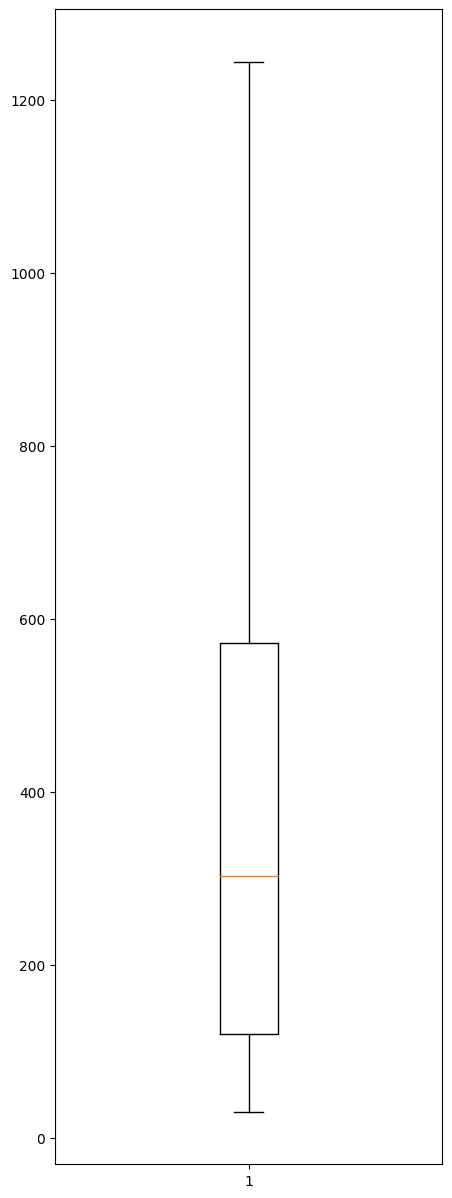

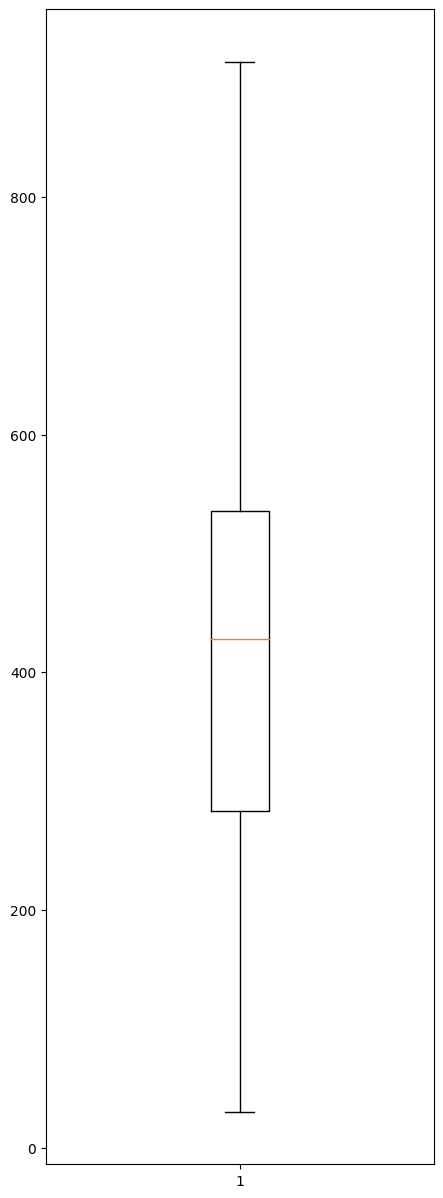

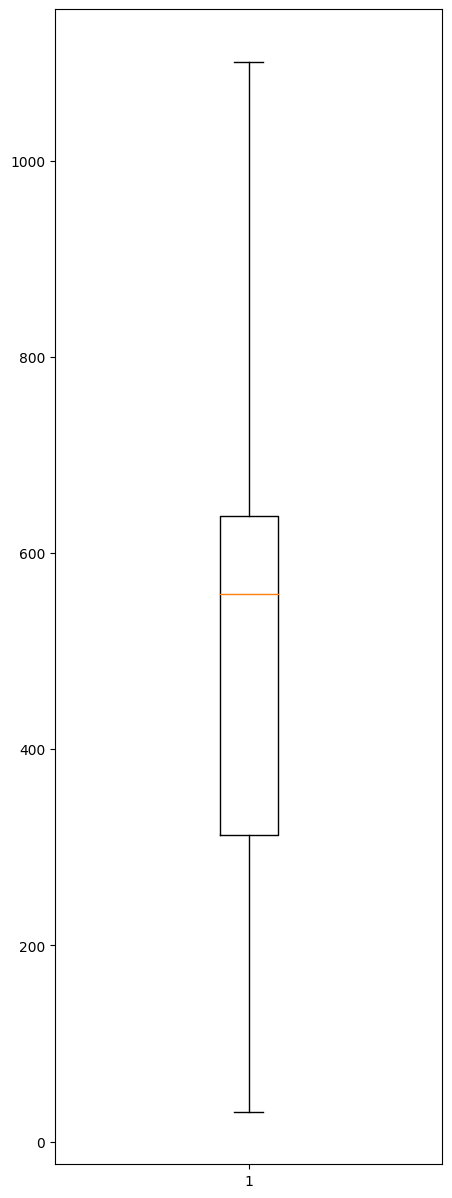

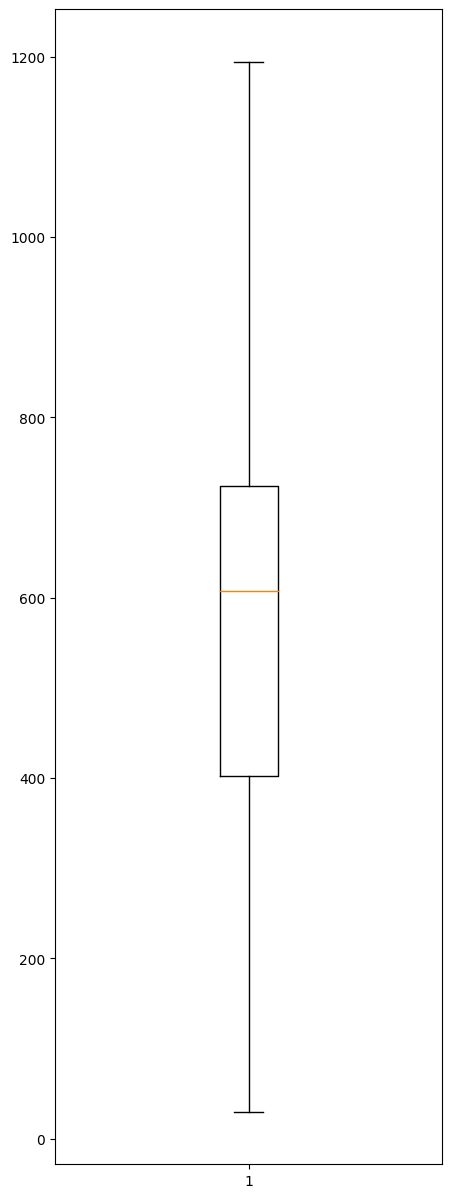

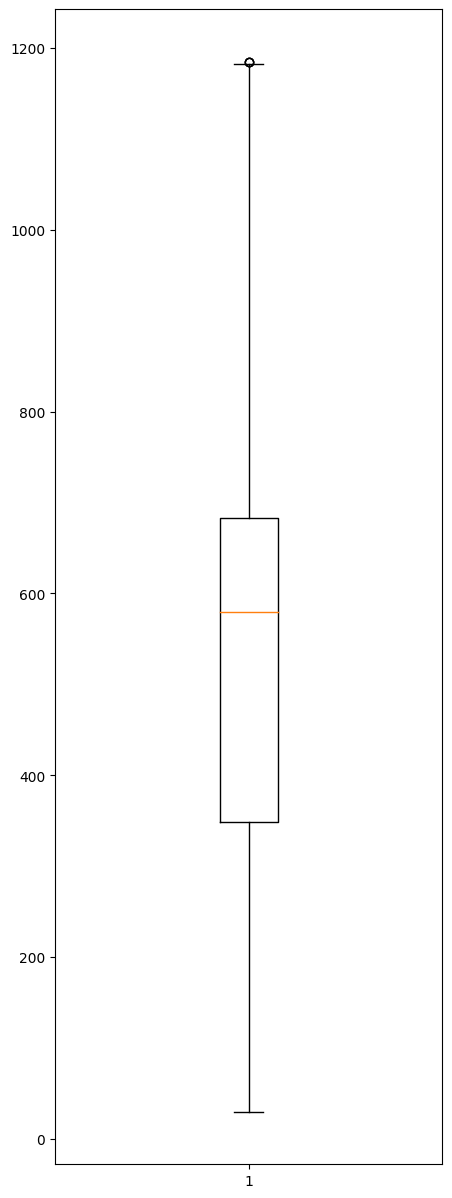

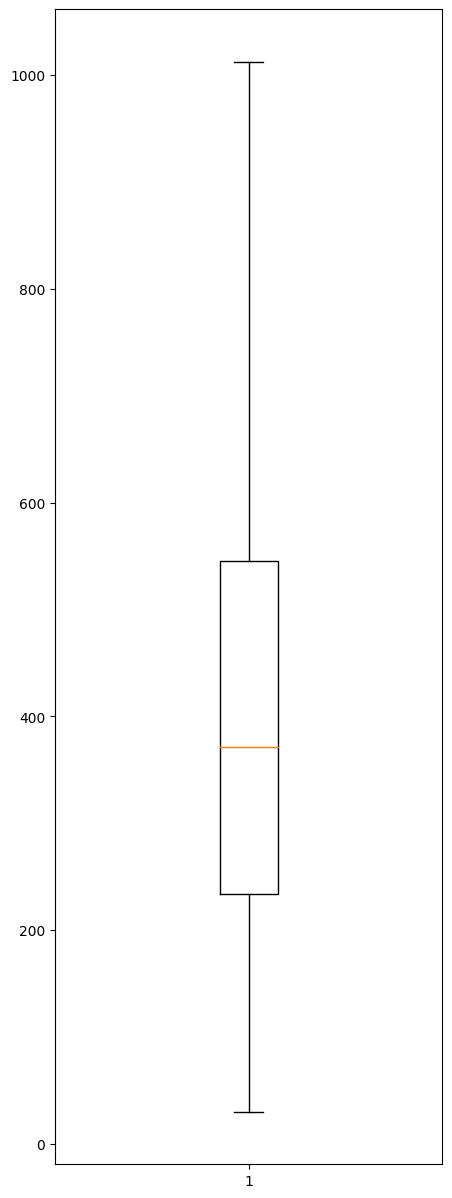

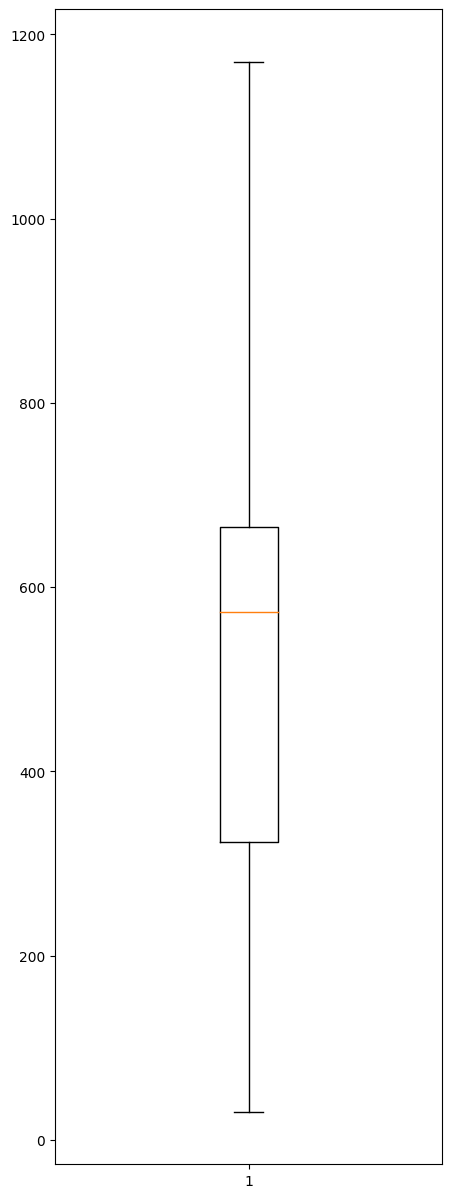

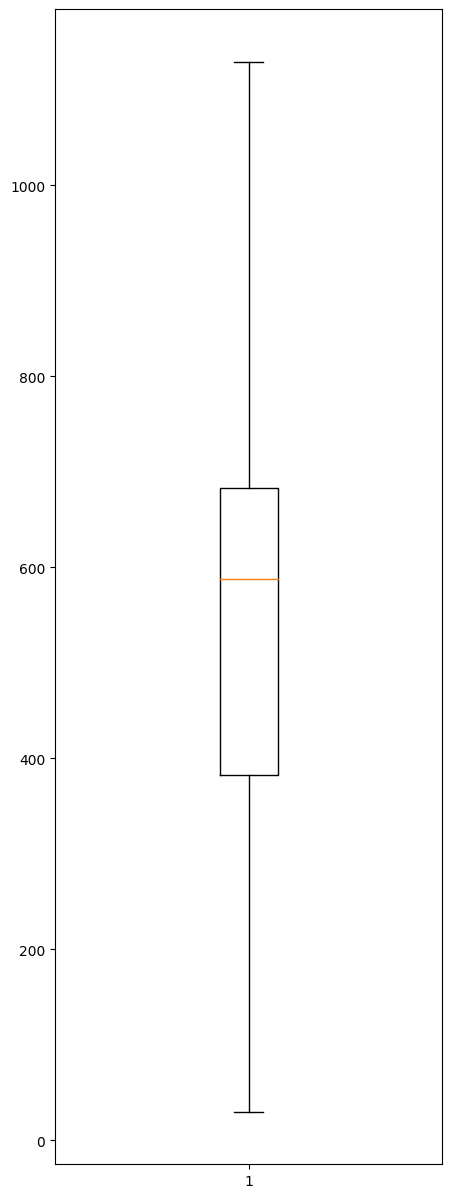

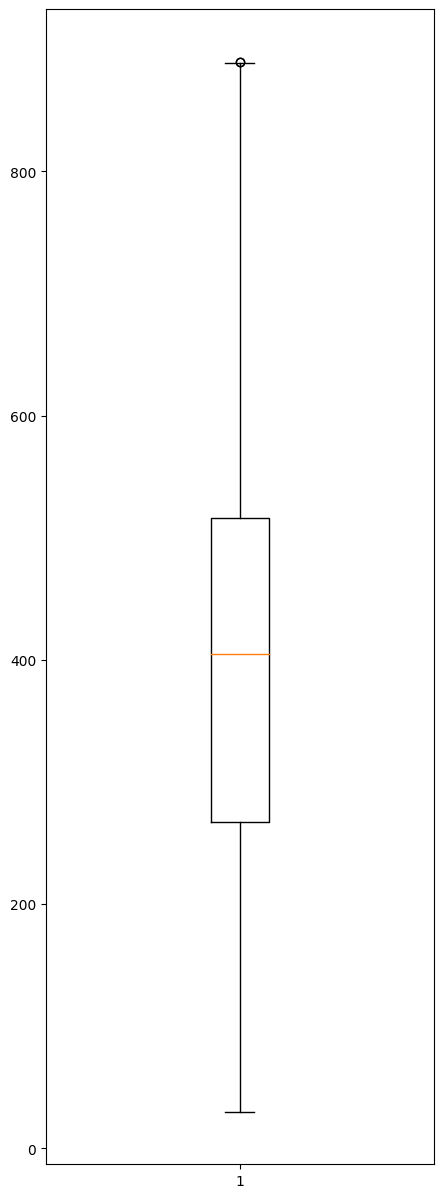

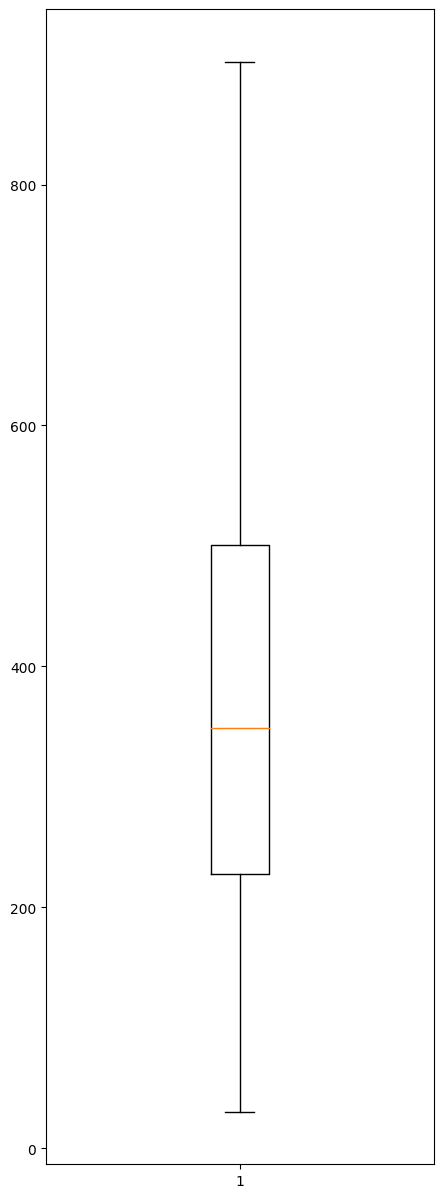

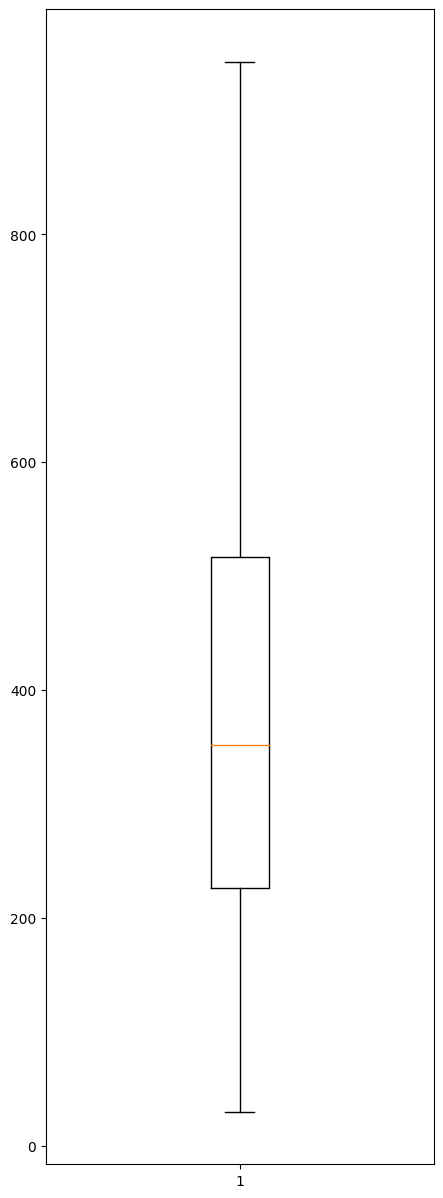

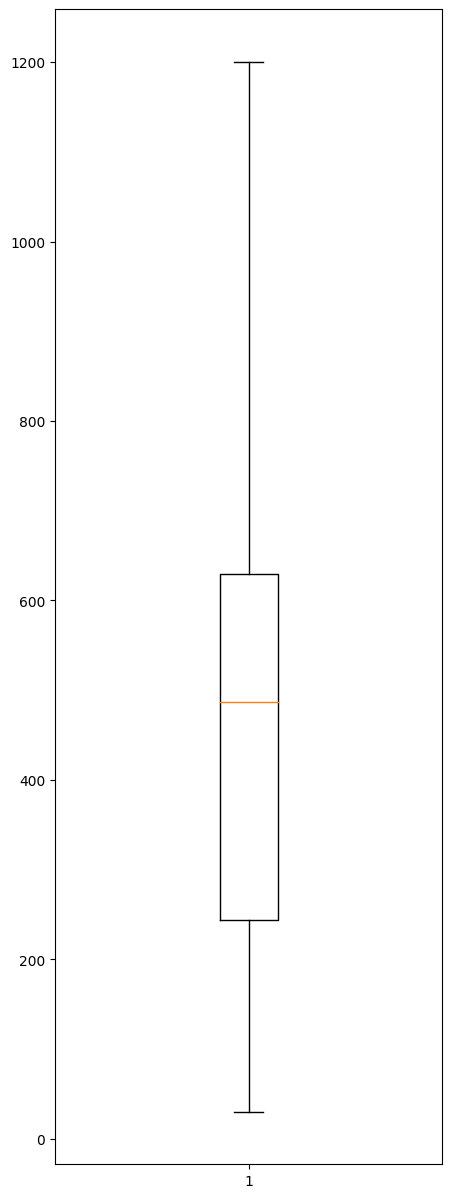

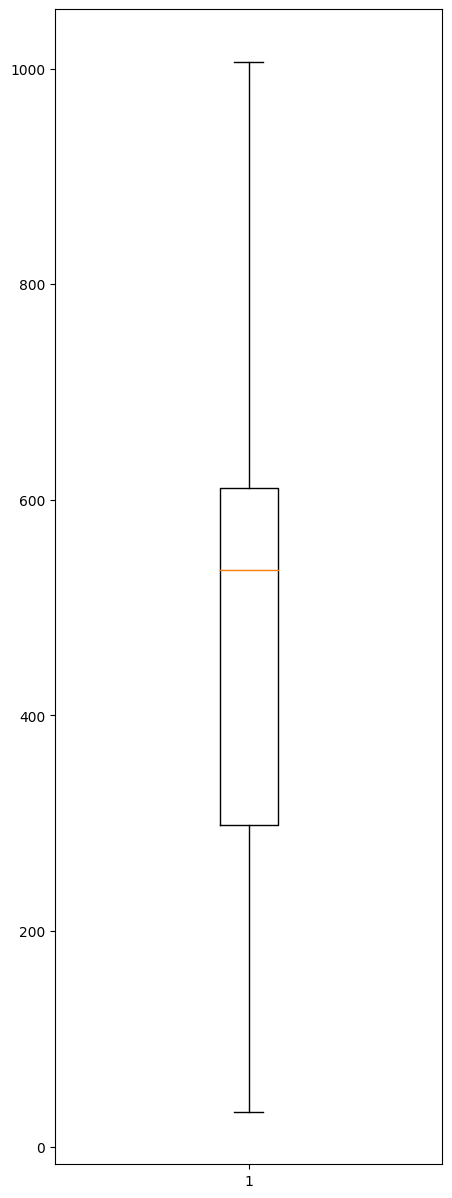

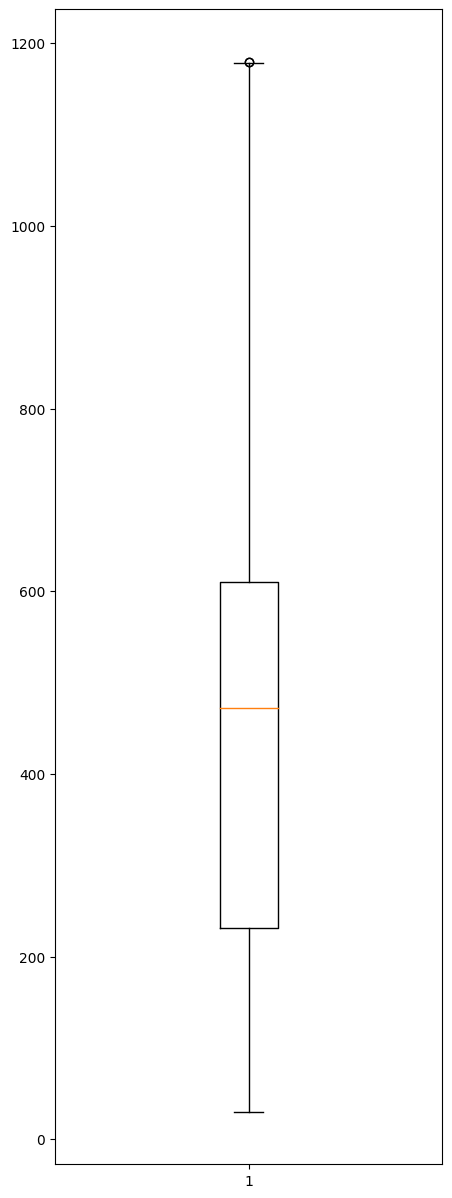

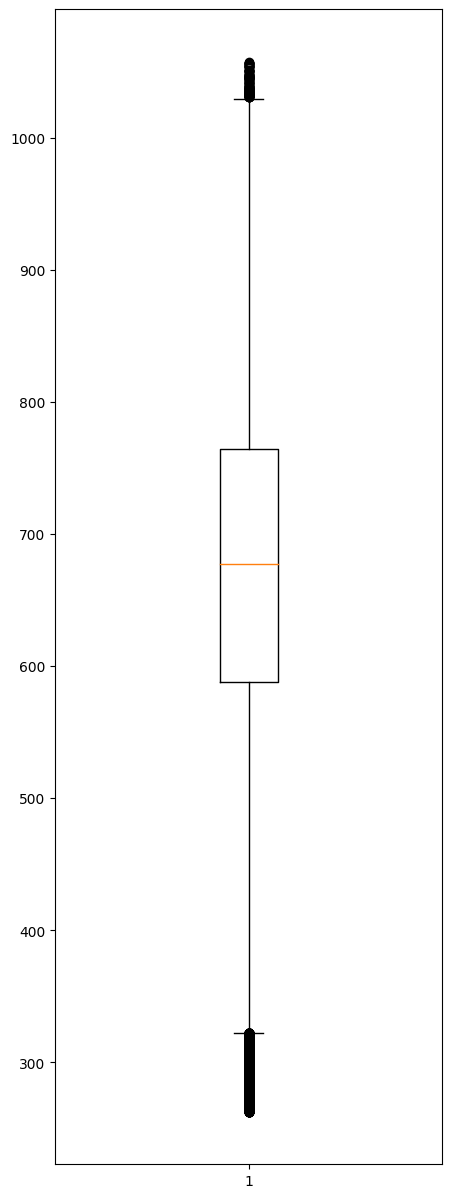

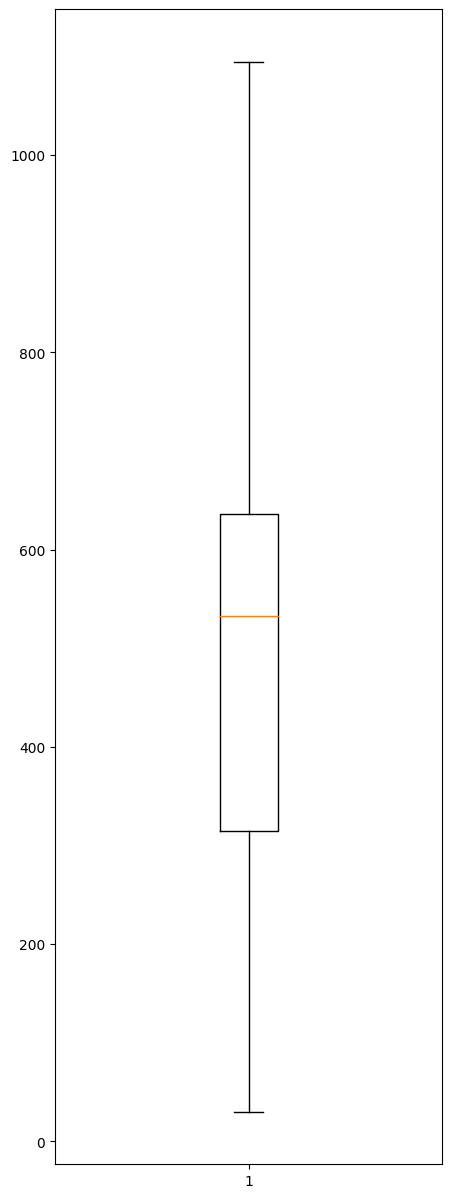

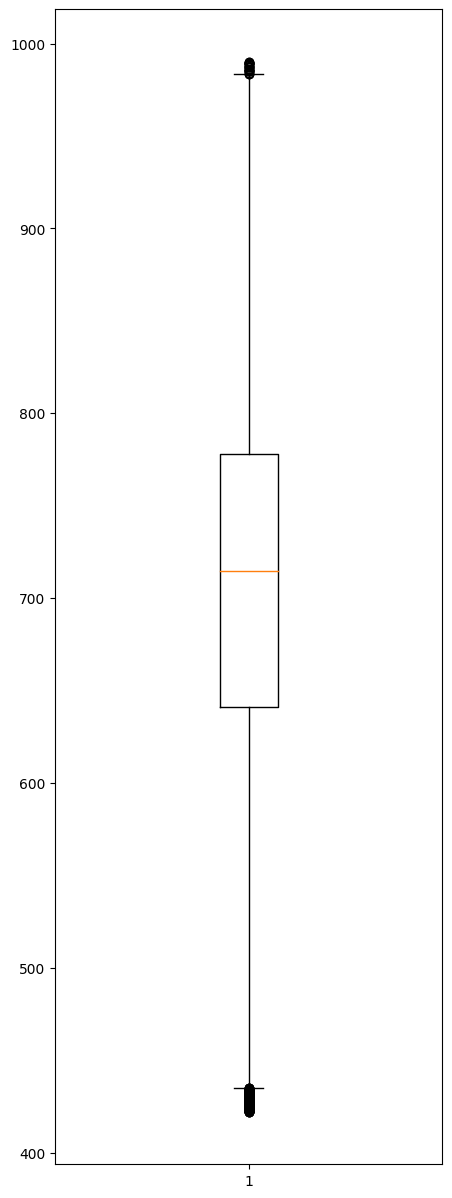

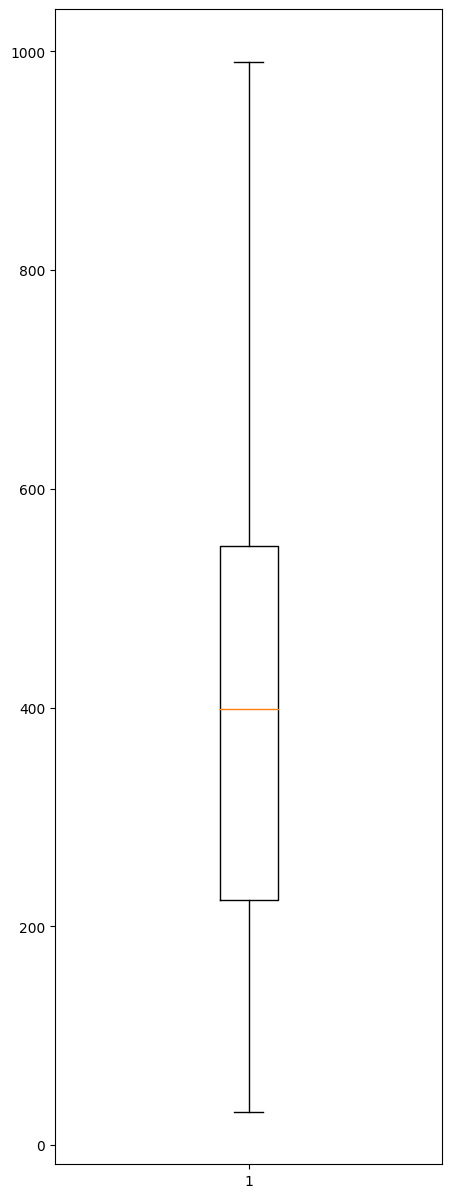

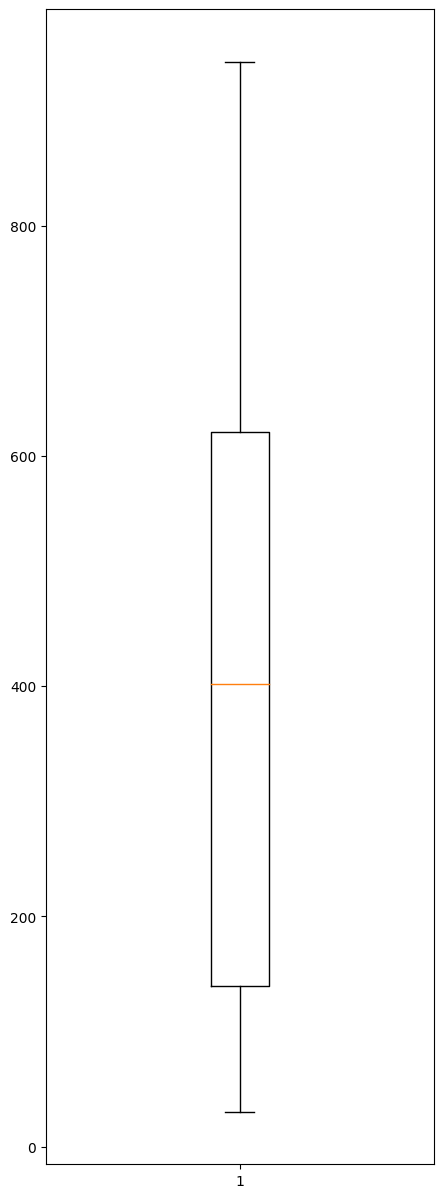

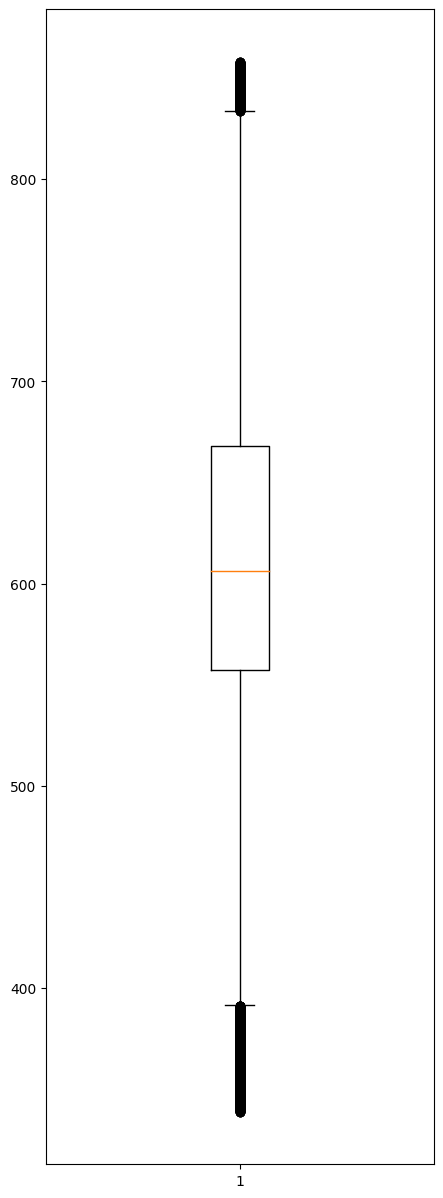

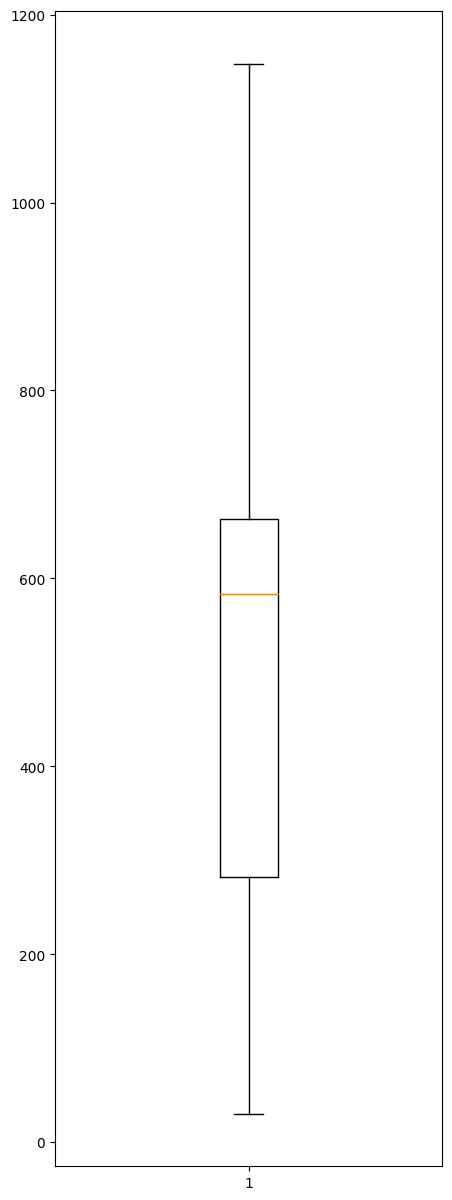

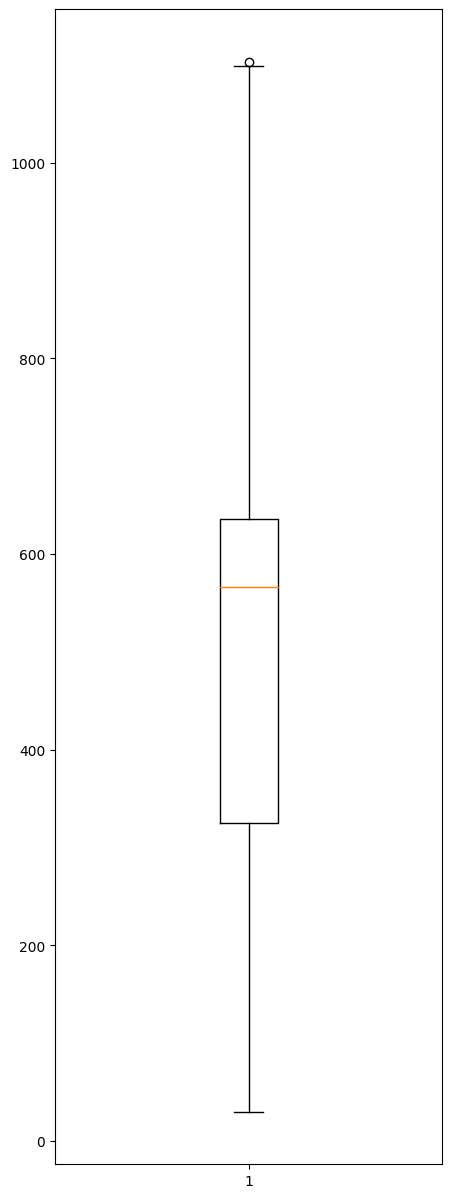

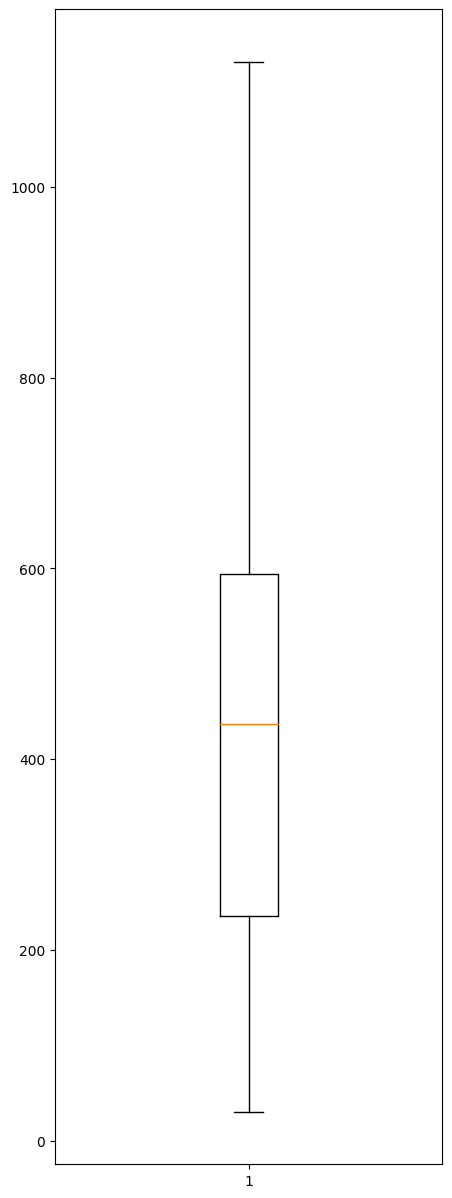

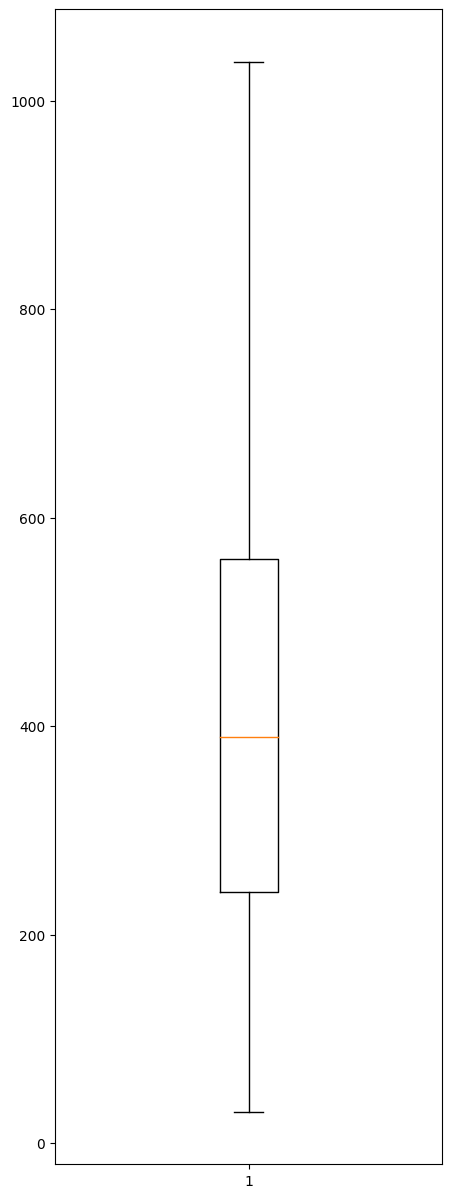

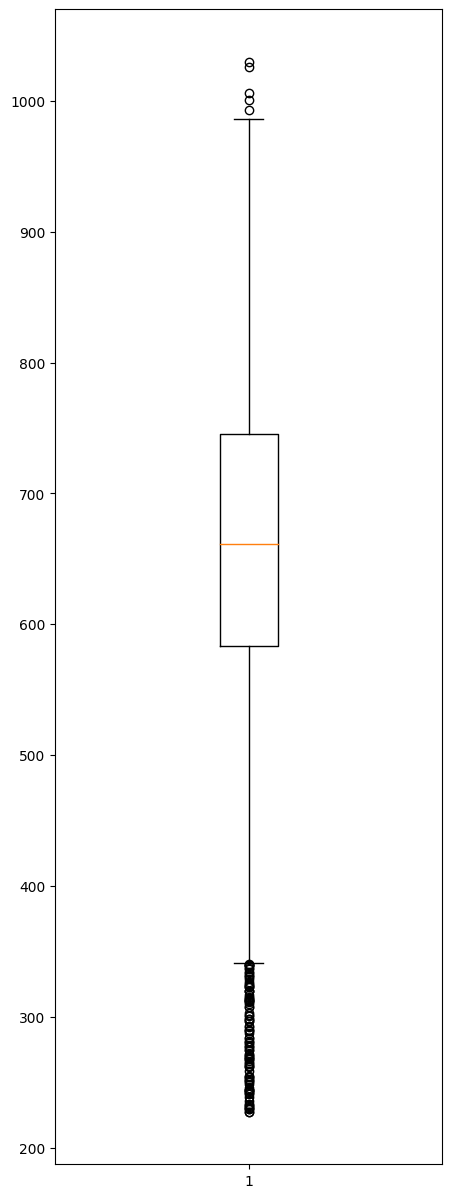

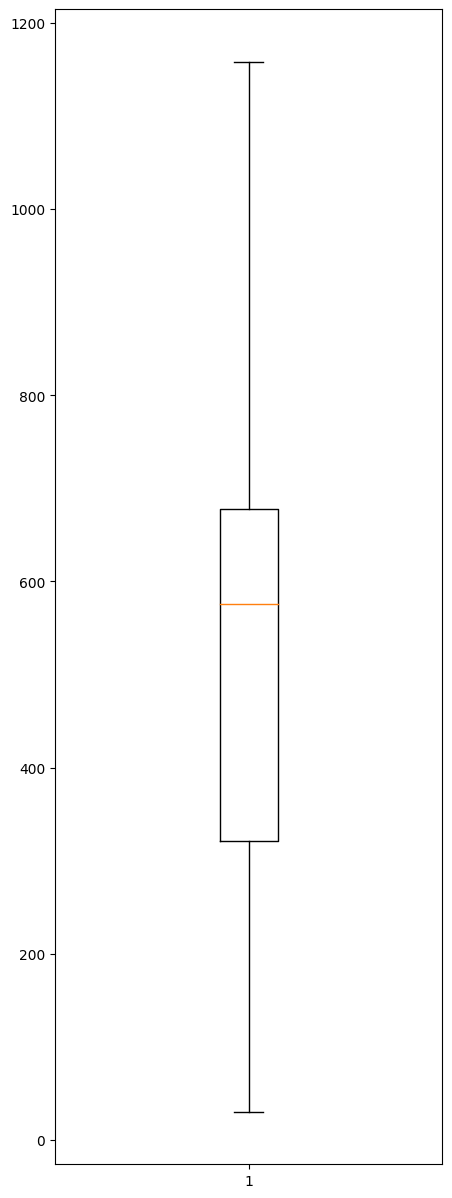

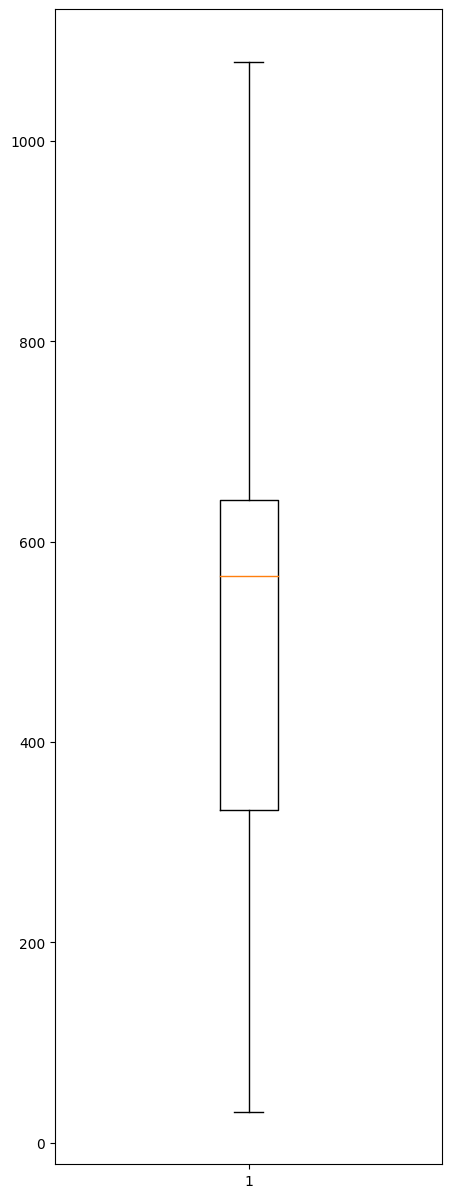

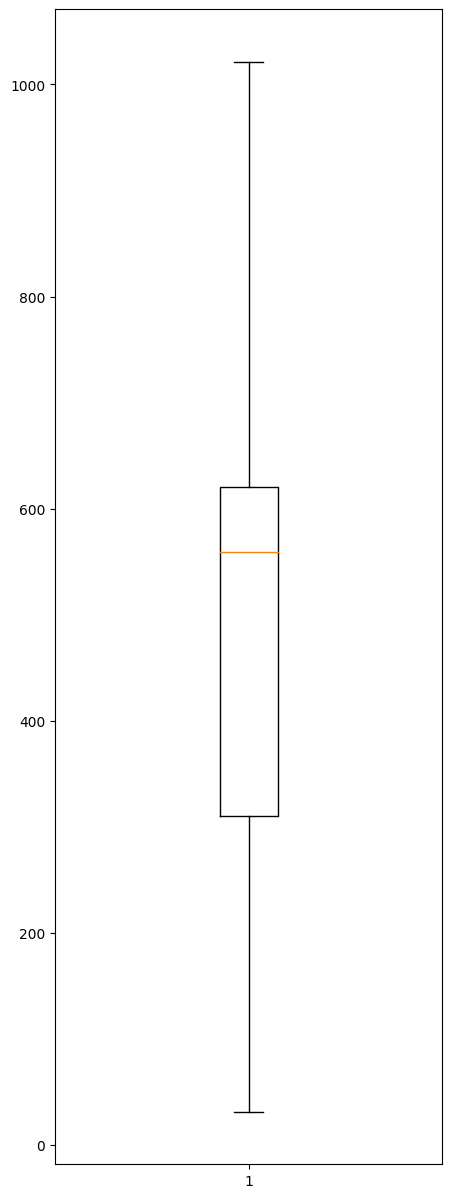

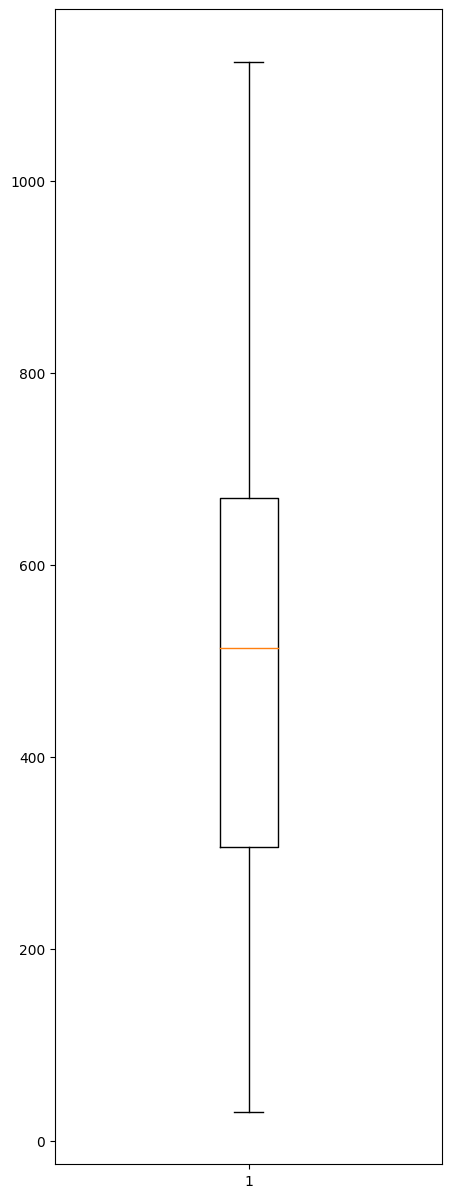

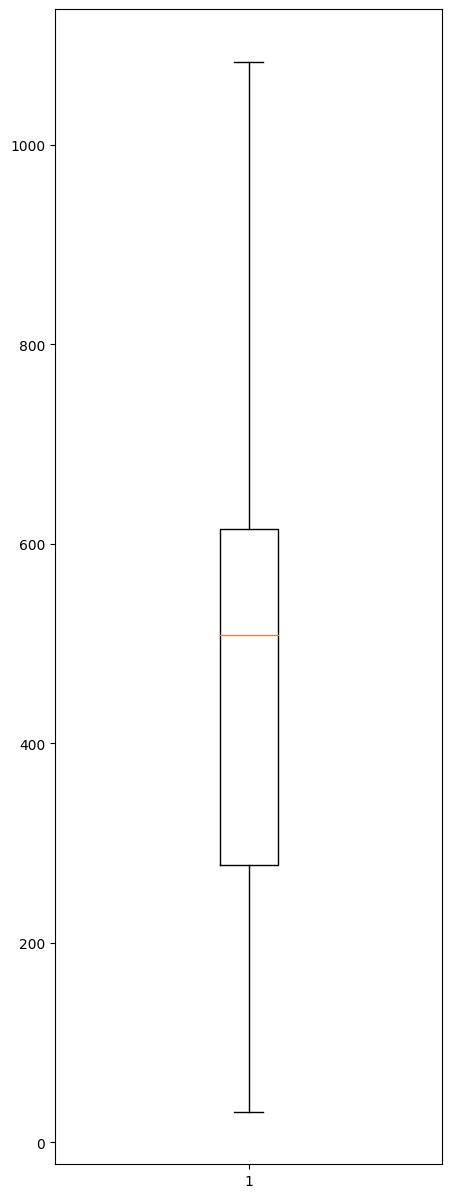

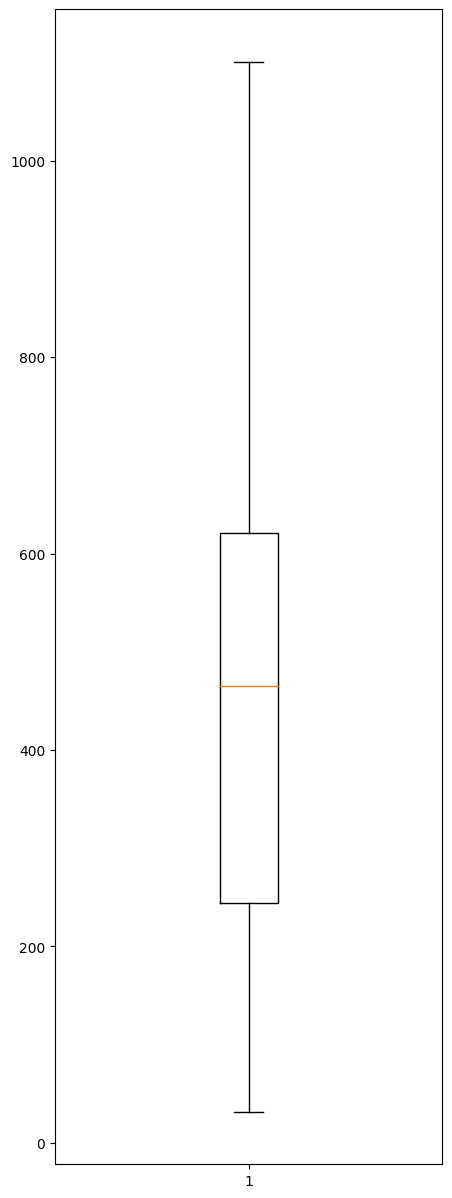

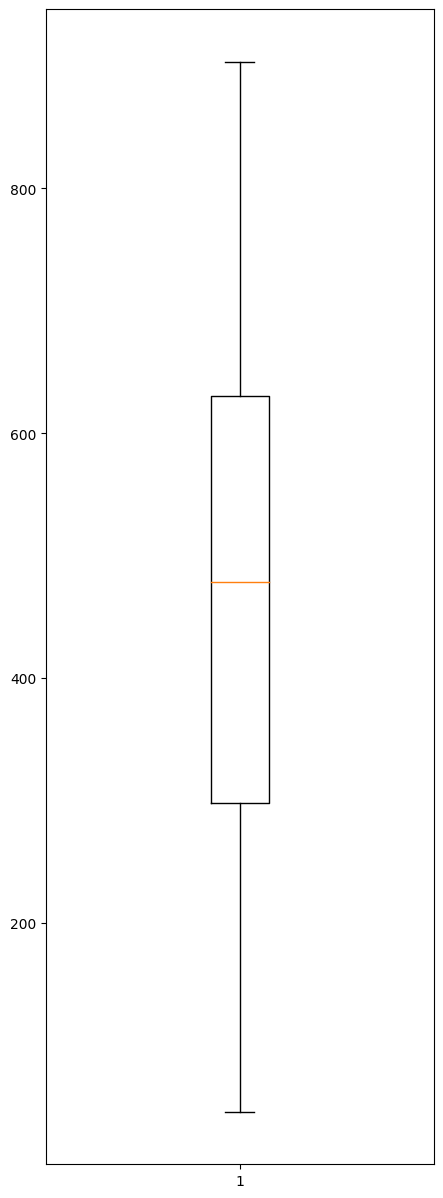

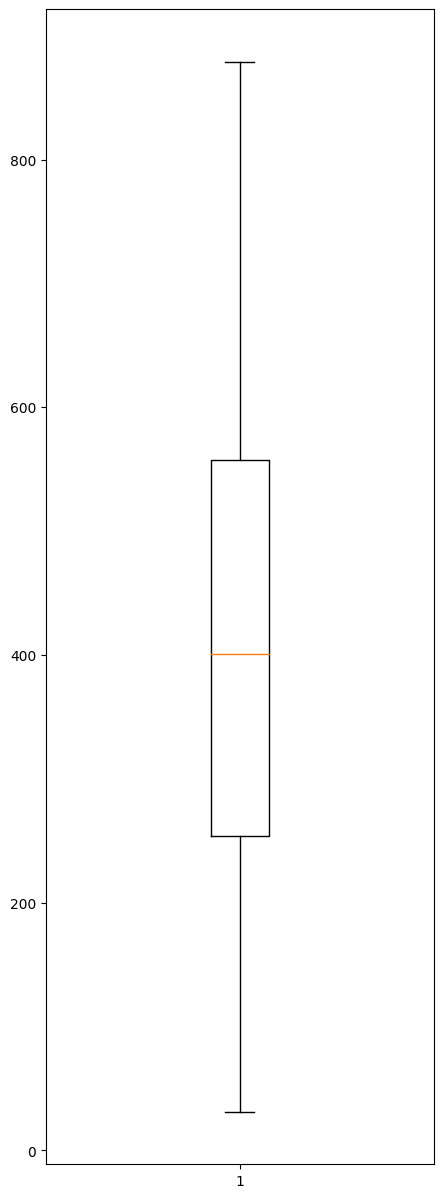

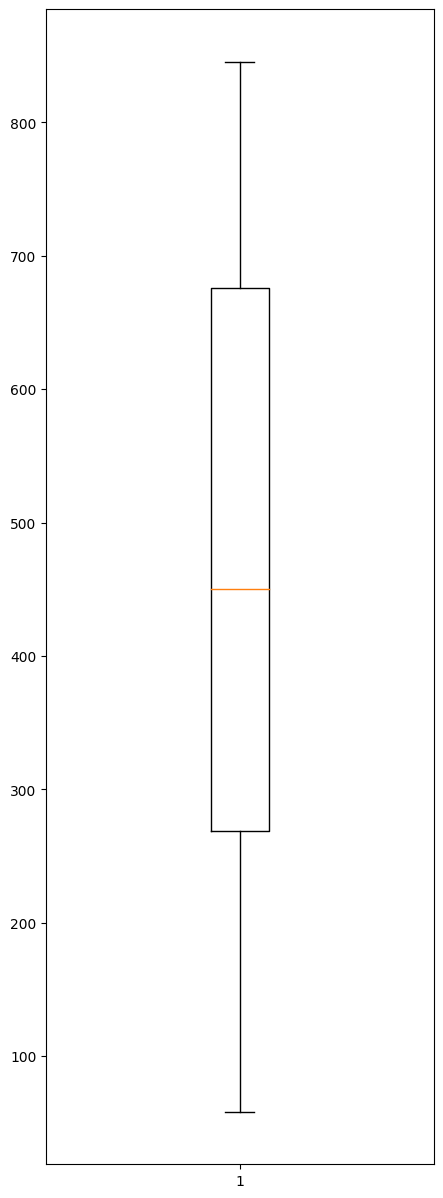

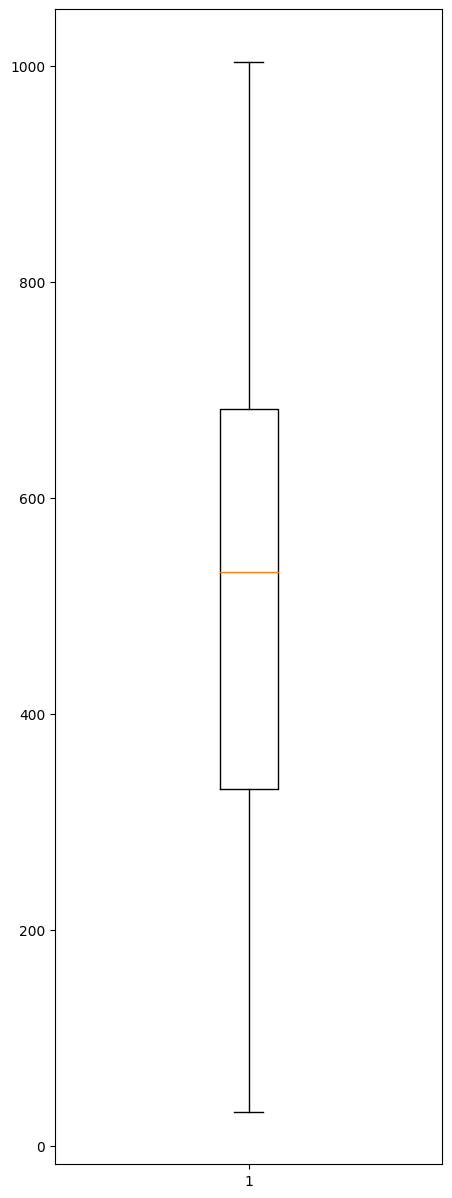

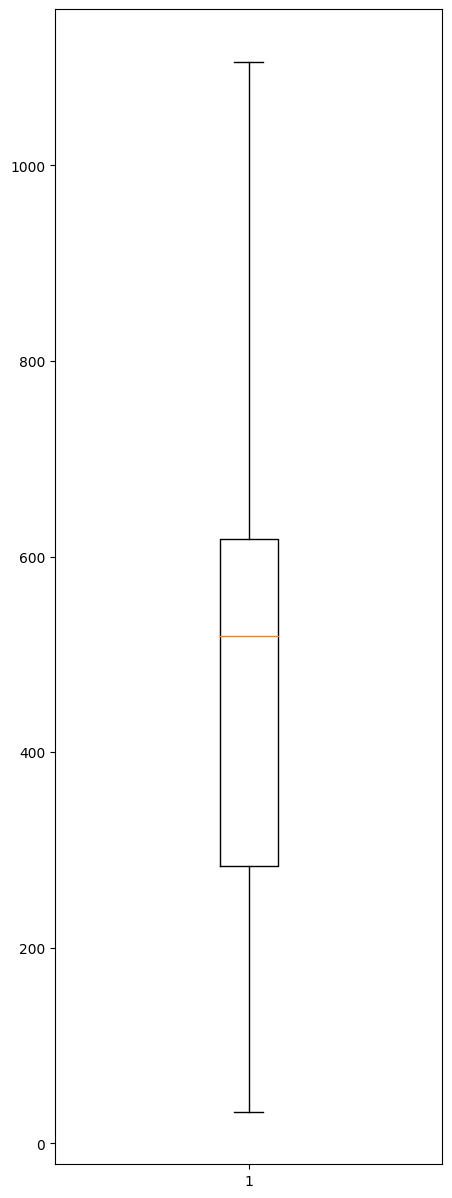

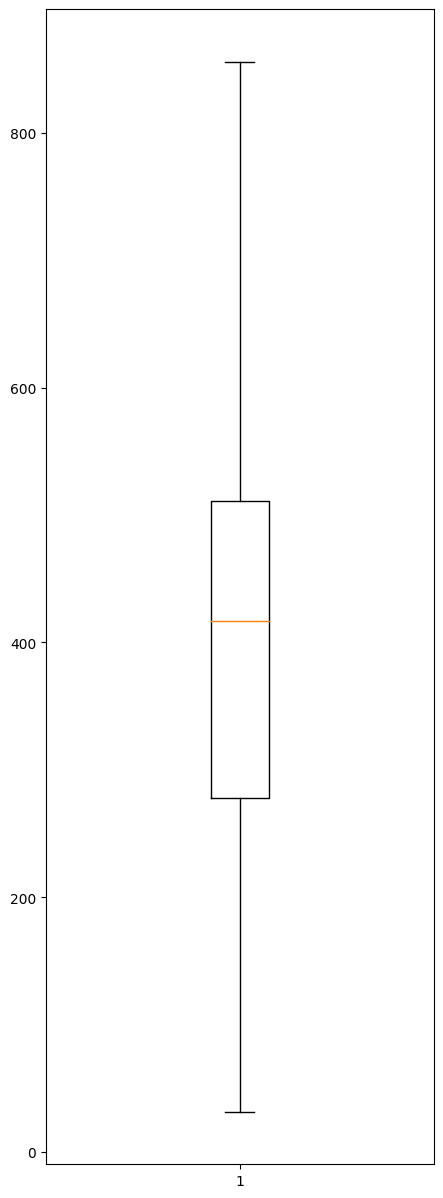

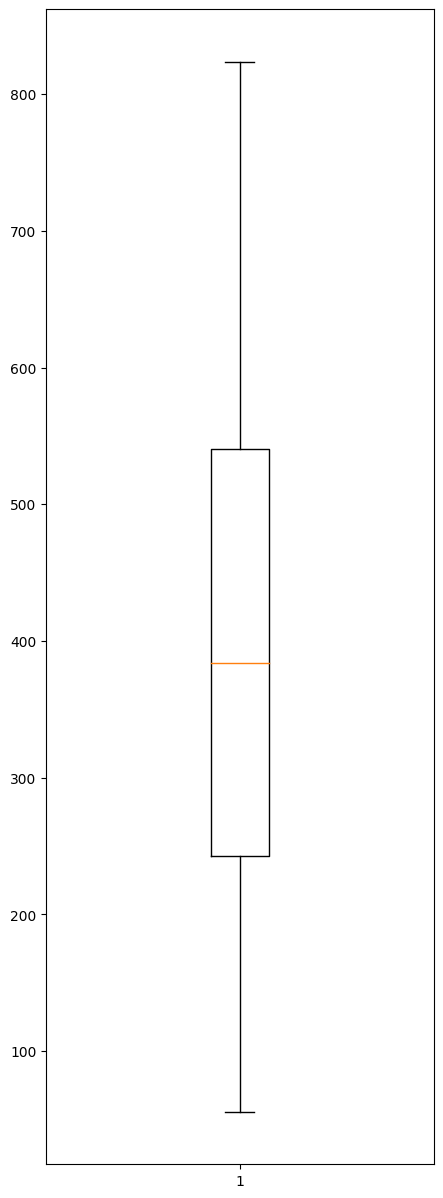

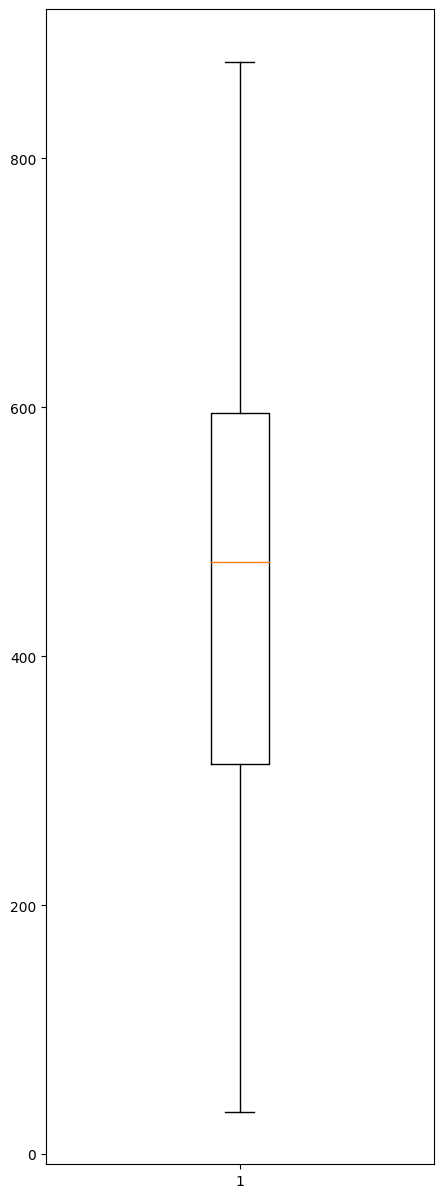

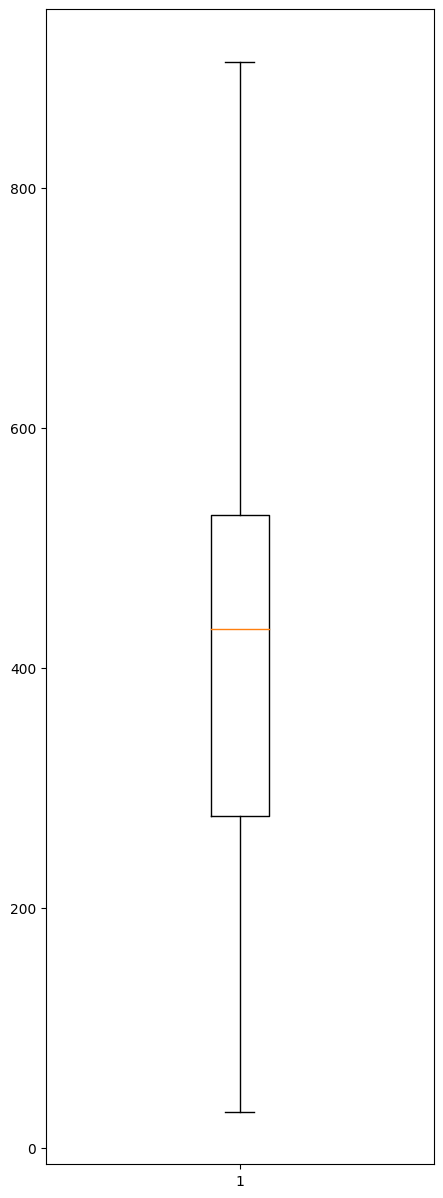

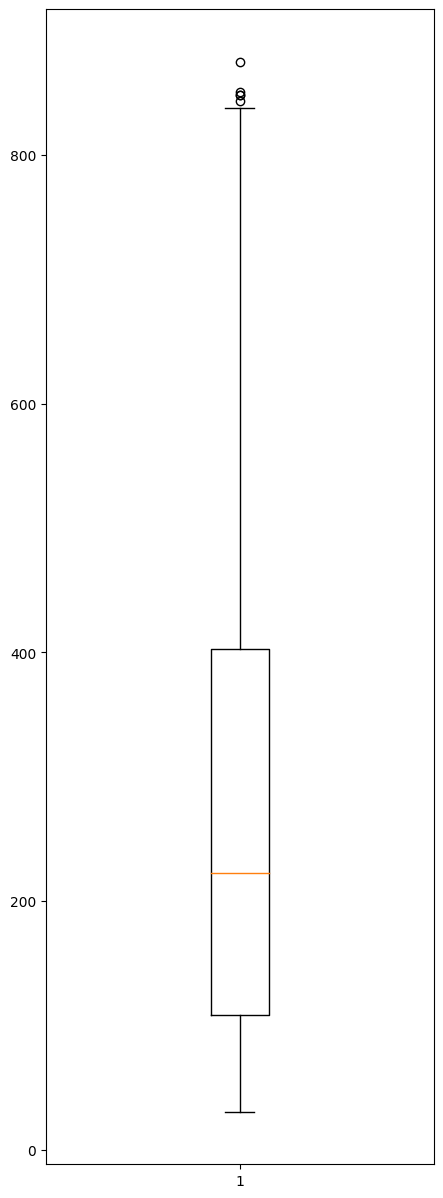

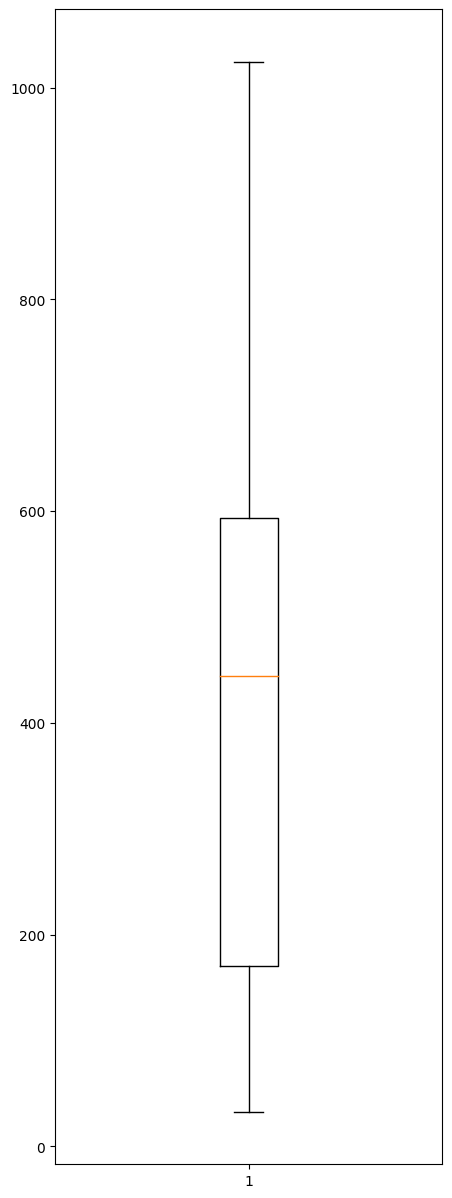

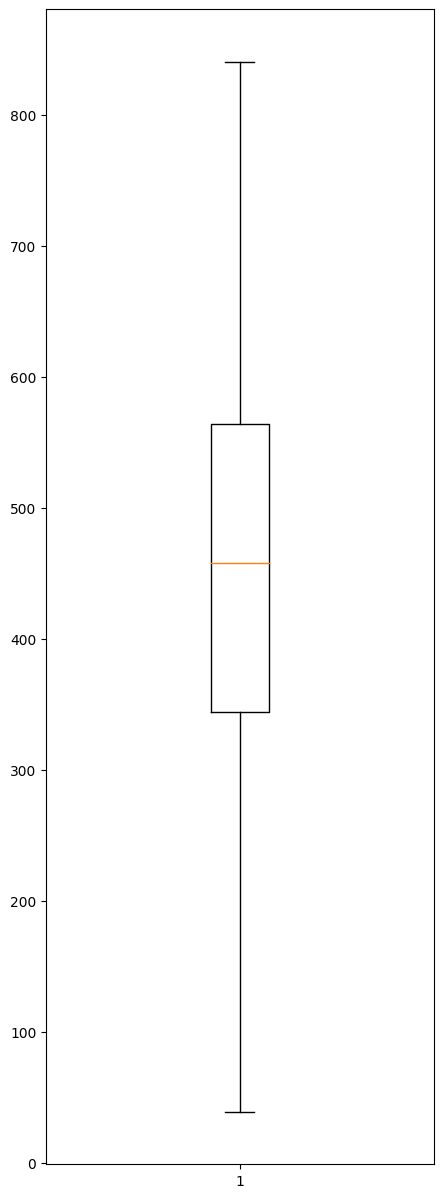

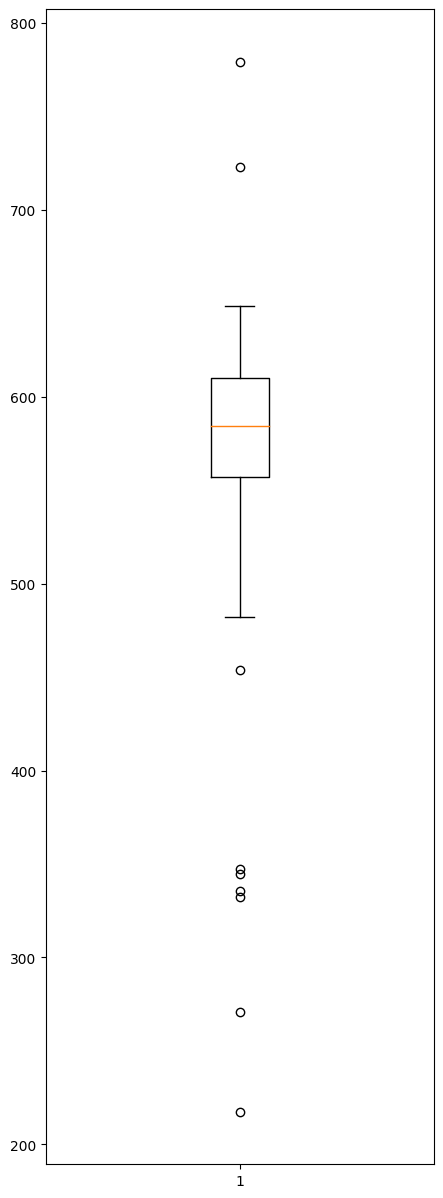

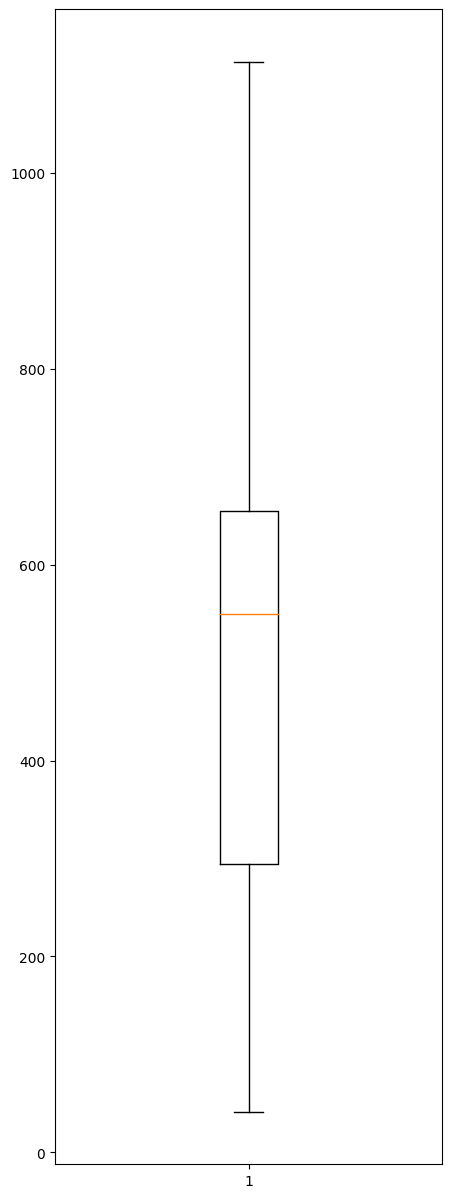

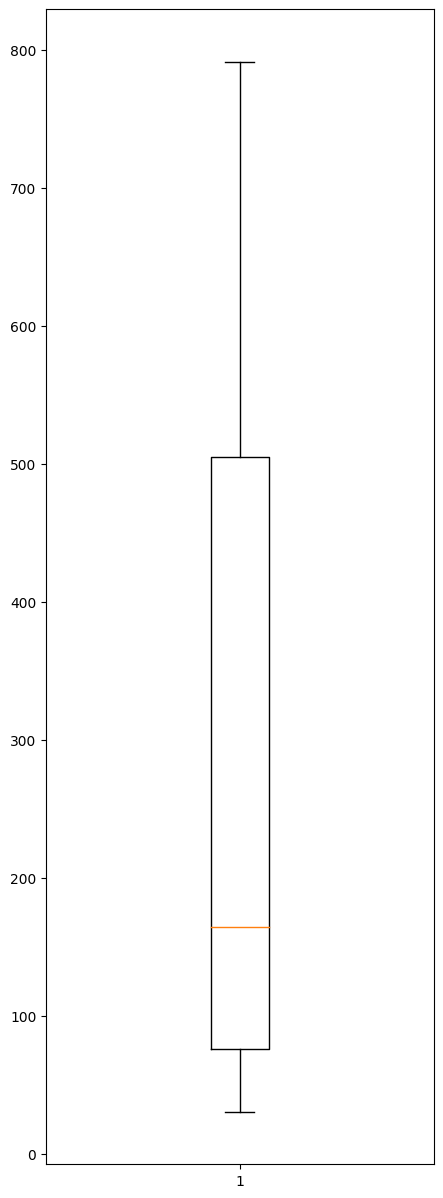

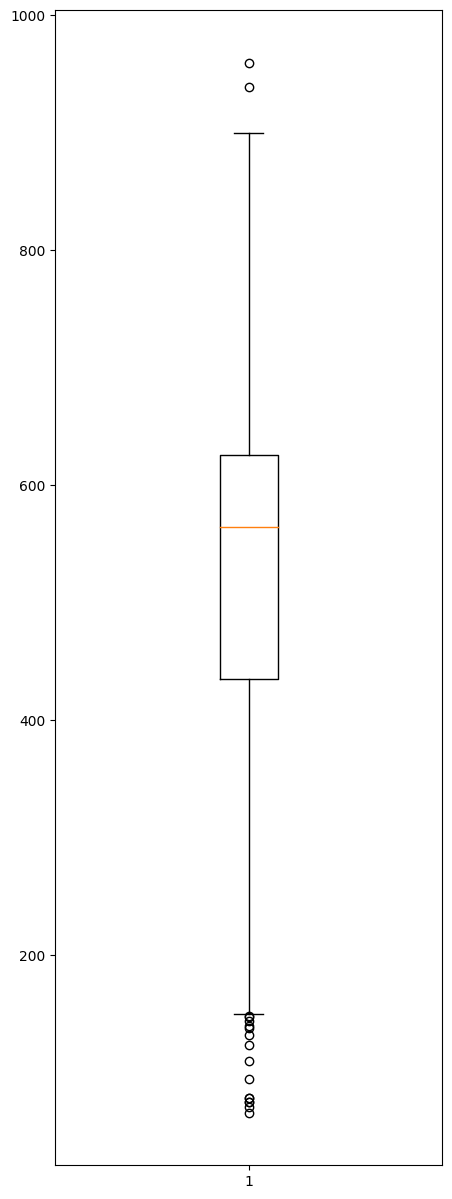

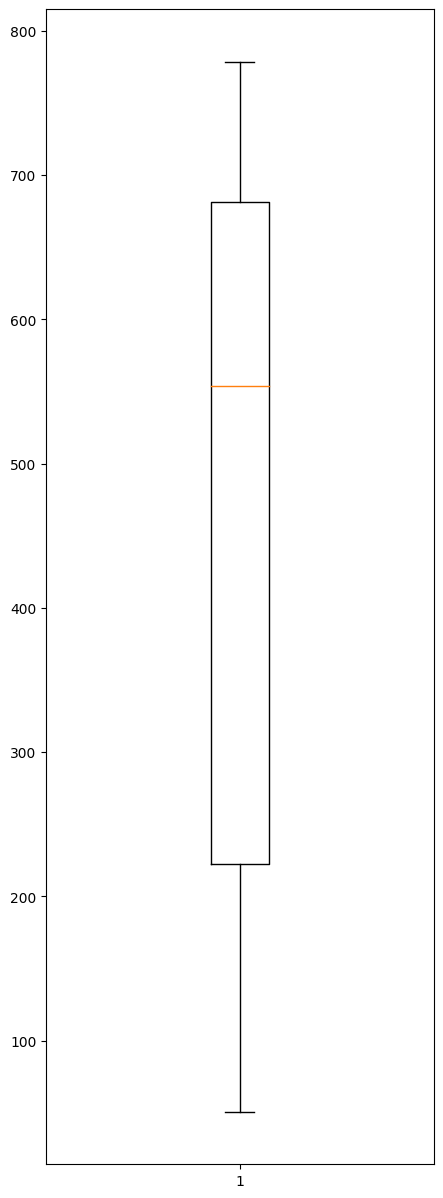

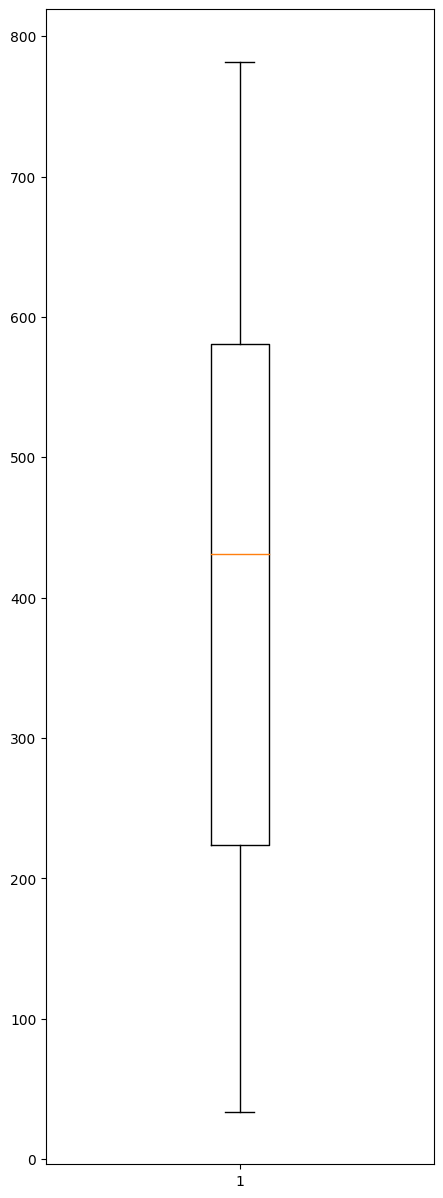

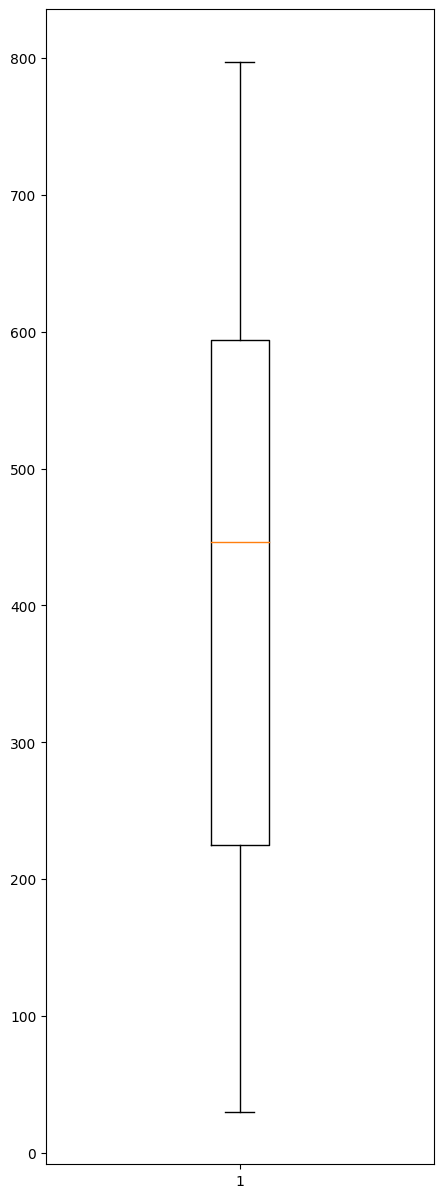

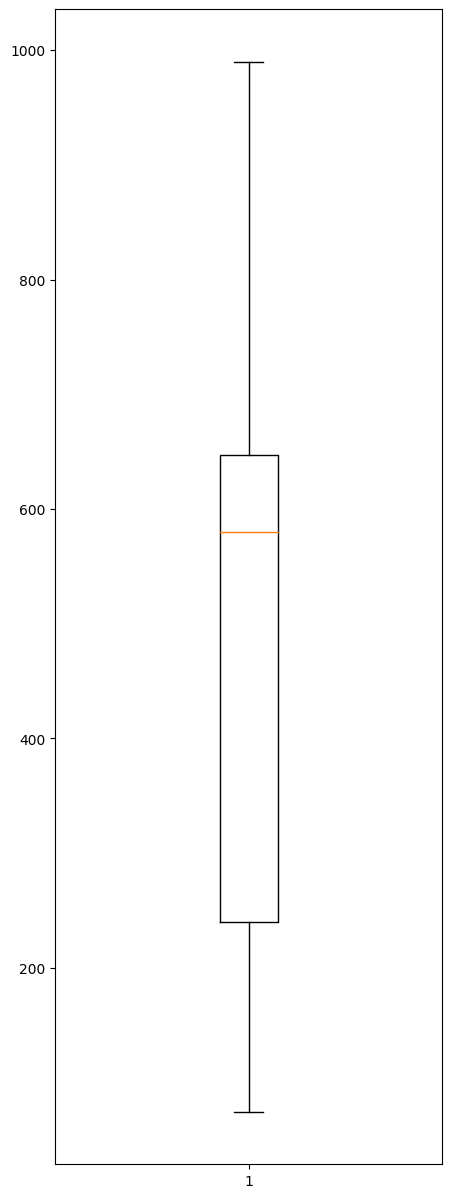

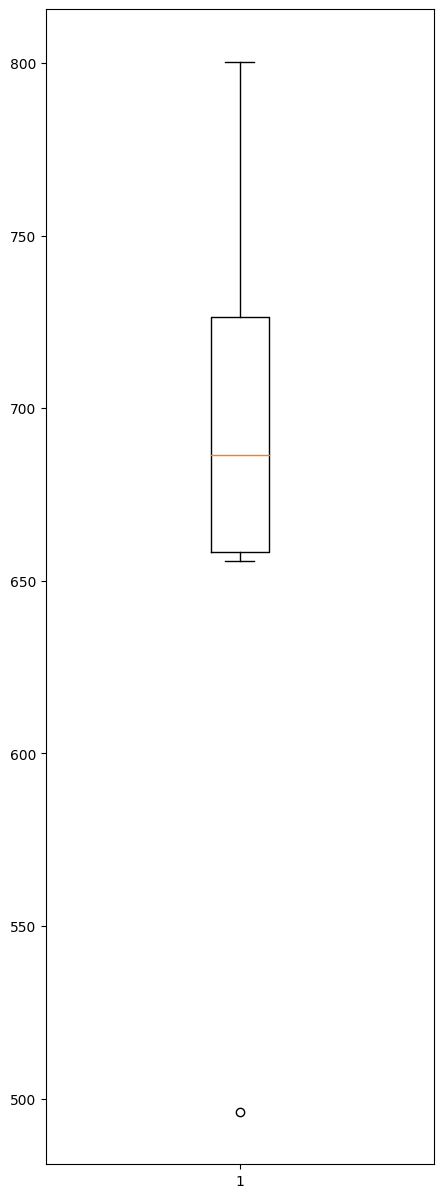

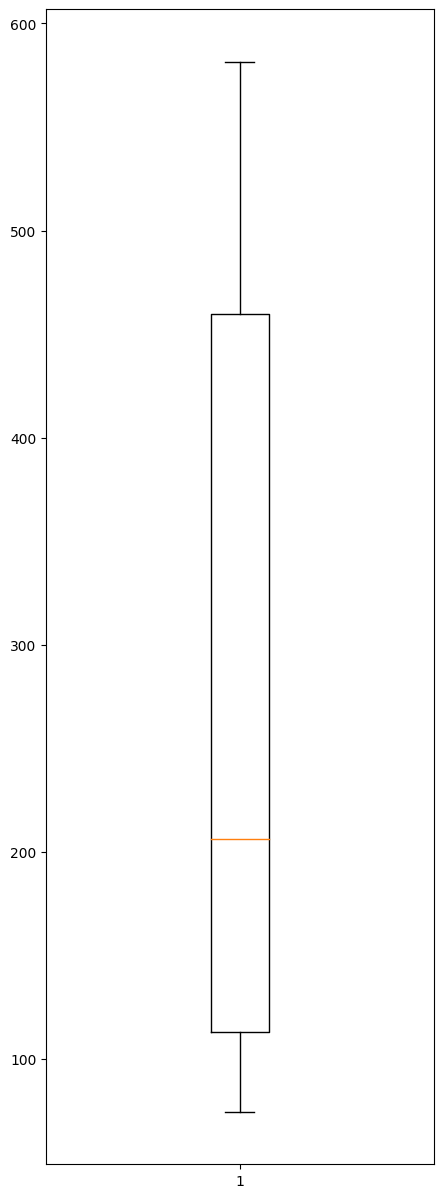

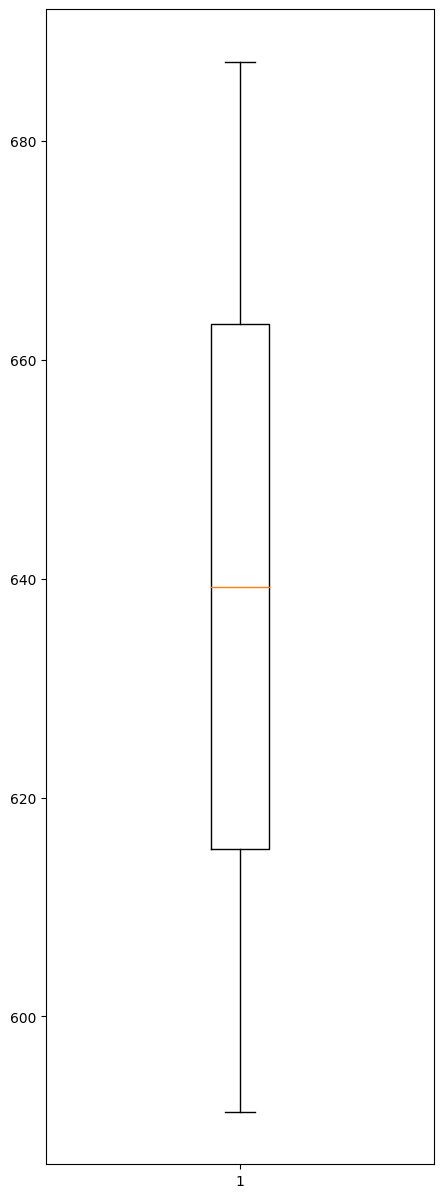

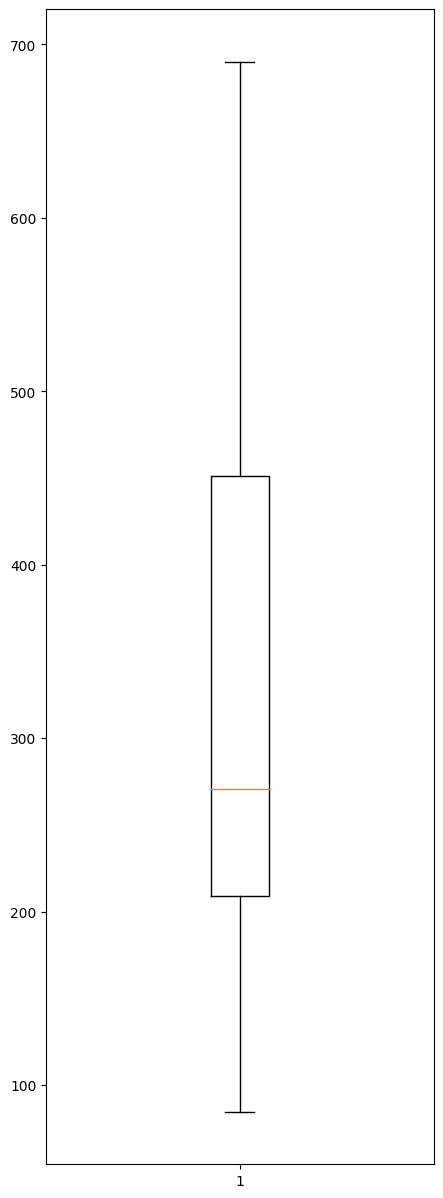

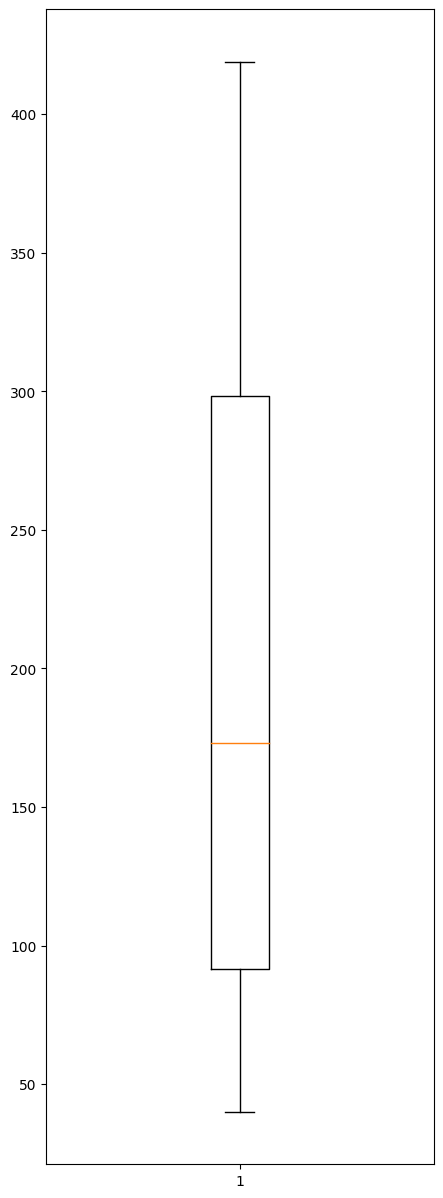

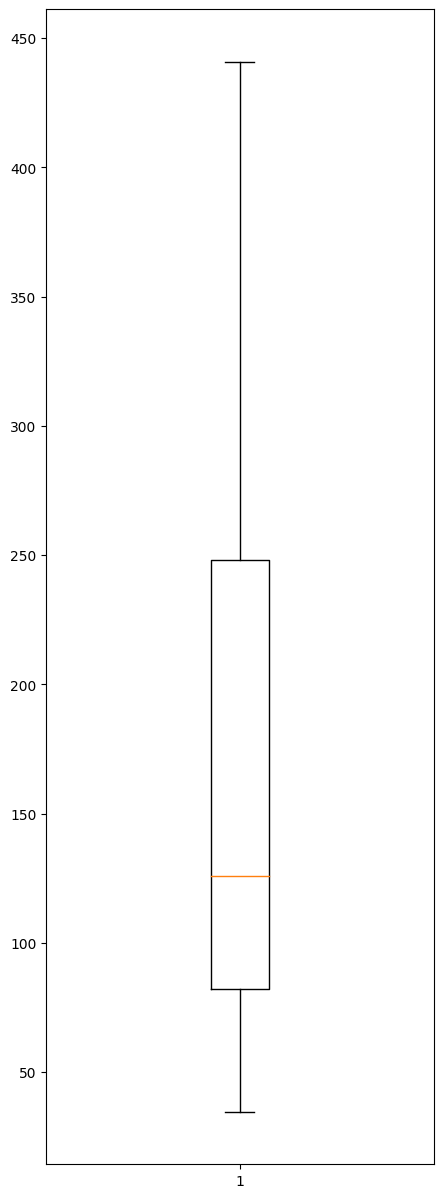

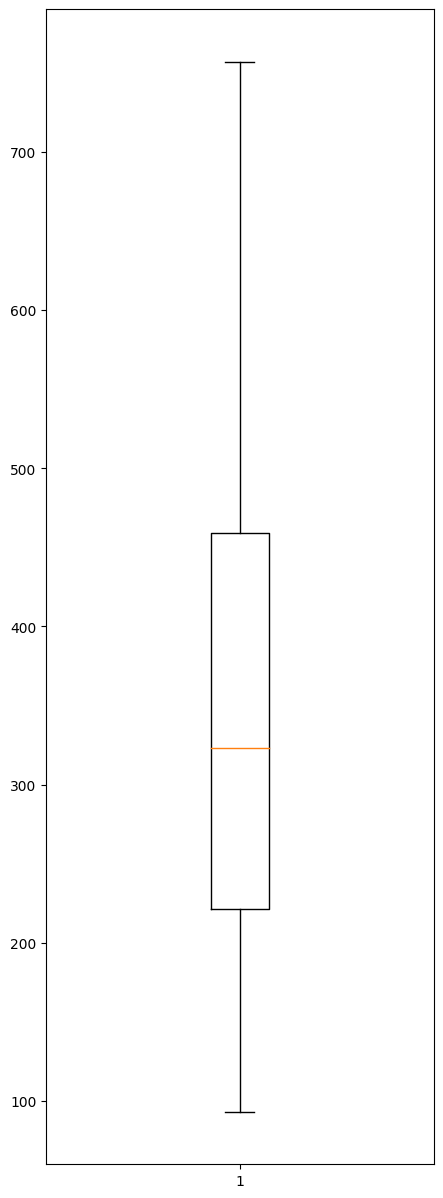

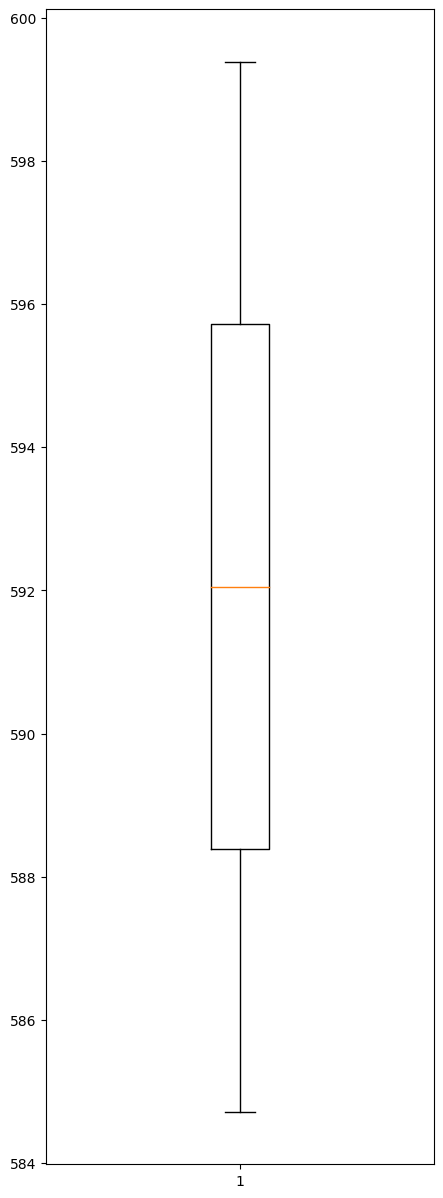

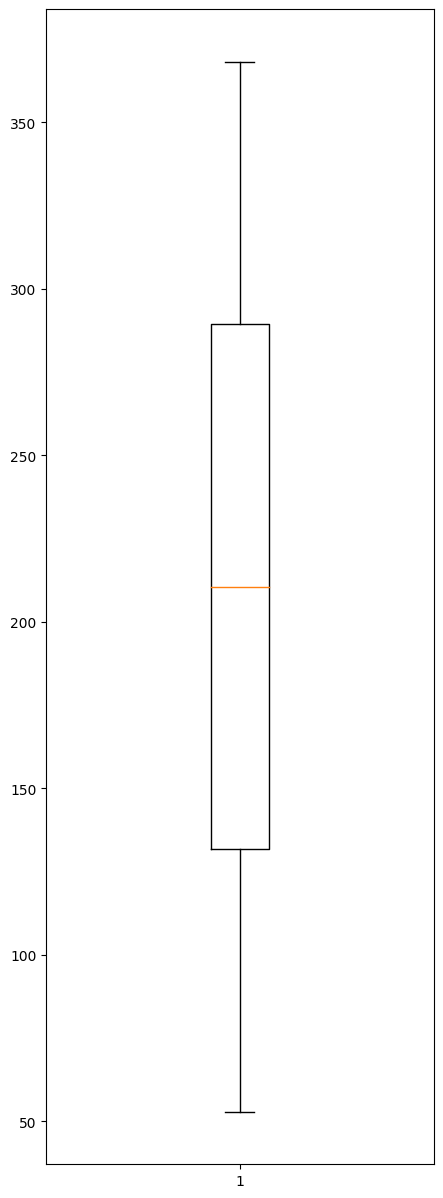

In [152]:
%matplotlib inline
for feature in list(data["ticket_type_nm"].unique()):
    fig, ax = plt.subplots(figsize=(5, 15))
    tu = data[data["ticket_type_nm"] == feature]
    B = ax.boxplot(tu["time_to_under"])
    


In [ ]:
import seaborn as sns
%matplotlib inline

feature_groups = ["ticket_type_nm", "station_nm", "line_nm", "entrance_nm"]

for f_group in feature_groups:
    for feature in list(data[f_group].unique())[1:10]:
        d = data[data[f_group] == feature]["time_to_under"]
        print(feature)
        print(len(list(d)))

        fig = sns.displot(d, kind = "kde")
        fig.set_axis_labels('time_to_under', feature)
        plt.show()

#params = new_df


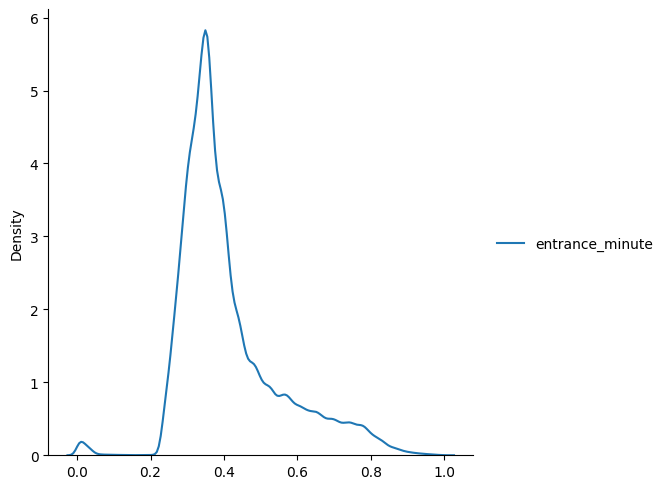

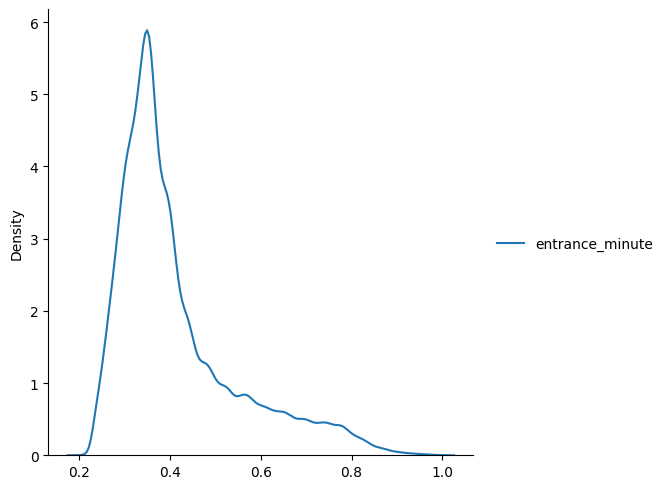

In [156]:
sns.displot(data[["entrance_minute"]], kind = "kde")
data = data[data["entrance_minute"] > 0.2]
sns.displot(data[["entrance_minute"]], kind = "kde")

In [164]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]


other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [other_items, categorical_features]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')
data_X = data[feature_names]
data_y = data["time_to_under"]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y,
                                                    random_state=1, test_size = 0.3)

print("НАЧАЛО ОБУЧЕНИЯ")
regr = MLPRegressor(random_state=1, max_iter=20, hidden_layer_sizes=(100, 100, 100, 100)).fit(X_train, y_train)
print("КОНЕЦ ОБУЧЕНИЯ")


y_pred = regr.predict(X_test)

r2_sc = r2_score(y_test, y_pred)



print("РЕЗУЛЬТАТЫ: ")
print("mape: " + str(mape(y_pred, y_test)))
print("mse: " + str(mse(y_pred, y_test)))
print(r2_sc)

НАЧАЛО ОБУЧЕНИЯ


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


КОНЕЦ ОБУЧЕНИЯ
РЕЗУЛЬТАТЫ: 
mape: 0.2637217124916094
mse: 22825.33767084692
0.5459455157682176


In [163]:
len(data_X.columns.to_list())

752

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y,
                                                    random_state=5, test_size = 0.8)
y_pred = regr.predict(X_test)
r2_sc = r2_score(y_test, y_pred)
print(r2_sc)


In [ ]:
data_X

Классификация нейронкой

In [ ]:
data = data.dropna()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]


other_items = ['entrance_minute', 'time_to_under', 'label', "holiday"]

big2d_list = [other_items, categorical_features]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')


data_X = data[feature_names]

data_Y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y,
                                                    random_state=1, test_size = 0.2, stratify = data_Y)

clf = MLPClassifier(random_state=1, max_iter=20, hidden_layer_sizes=(100, 100, 100, 100, 100)).fit(X_train, y_train)

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred, average='micro')
print("recall = ", recall)

print(classification_report(y_pred, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [other_items, categorical_features]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')

data_X = data[feature_names]

data_Y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y,
                                                    random_state=1, test_size = 0.4, stratify = data_Y)

clf = RandomForestClassifier(n_estimators=2000, max_depth = 1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred, average='micro')
print("recall = ", recall)

print(classification_report(y_pred, y_test))

In [ ]:
recall = recall_score(y_test, y_pred, average='micro')
recall